# COVID19 Global Forecasting (data up to Mar 24, 2020)

Author: Vincent Lee Wai Seng
Date: 03/25/2020

**Forecast daily COVID-19 spread in regions around world**

**Background**

The White House Office of Science and Technology Policy (OSTP) pulled together a coalition research groups and companies (including Kaggle) to prepare the COVID-19 Open Research Dataset (CORD-19) to attempt to address key open scientific questions on COVID-19. Those questions are drawn from National Academies of Sciences, Engineering, and Medicine’s (NASEM) and the World Health Organization (WHO).

**The Challenge**

Kaggle is launching two companion COVID-19 forecasting challenges to help answer a subset of the NASEM/WHO questions. While the challenge involves forecasting confirmed cases and fatalities between March 25 and April 22 by region, the primary goal isn't to produce accurate forecasts. It’s to identify factors that appear to impact the transmission rate of COVID-19.

You are encouraged to pull in, curate and share data sources that might be helpful. If you find variables that look like they impact the transmission rate, please share your finding in a notebook.

As the data becomes available, we will update the leaderboard with live results based on data made available from the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).

We have received support and guidance from health and policy organizations in launching these challenges. We're hopeful the Kaggle community can make valuable contributions to developing a better understanding of factors that impact the transmission of COVID-19.

## Import libraries

In [89]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA, ARMAResults 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Read data

In [2]:
datapath   = 'C:/Users/vincentlee/Desktop/datascienceprojects/Kaggle/covid19/'
train      = pd.read_csv(datapath+'train.csv')
test       = pd.read_csv(datapath+'test.csv')

In [3]:
print("Train dataset: ", train.head())
print("Train period: ", train.Date.min(), train.Date.max())
print("Test dataset: ", test.head())
print("Test period: ", test.Date.min(), test.Date.max())

Train dataset:     Id Province/State Country/Region   Lat  Long        Date  ConfirmedCases  \
0   1            NaN    Afghanistan  33.0  65.0  2020-01-22             0.0   
1   2            NaN    Afghanistan  33.0  65.0  2020-01-23             0.0   
2   3            NaN    Afghanistan  33.0  65.0  2020-01-24             0.0   
3   4            NaN    Afghanistan  33.0  65.0  2020-01-25             0.0   
4   5            NaN    Afghanistan  33.0  65.0  2020-01-26             0.0   

   Fatalities  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
Train period:  2020-01-22 2020-03-24
Test dataset:     ForecastId Province/State Country/Region   Lat  Long        Date
0           1            NaN    Afghanistan  33.0  65.0  2020-03-12
1           2            NaN    Afghanistan  33.0  65.0  2020-03-13
2           3            NaN    Afghanistan  33.0  65.0  2020-03-14
3           4            NaN    Afghanistan  33.0  65.0  2020-03-15
4           5        

**Goal of Analysis**:

Forecast confirmedcases and fatalities from March 12 to April 23 2020 using data from Jan 22, 2020 to March 22 2020. 

## Pre-processing data

In [4]:
# check metadata of train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17892 entries, 0 to 17891
Data columns (total 8 columns):
Id                17892 non-null int64
Province/State    8190 non-null object
Country/Region    17892 non-null object
Lat               17892 non-null float64
Long              17892 non-null float64
Date              17892 non-null object
ConfirmedCases    17892 non-null float64
Fatalities        17892 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.1+ MB


In [5]:
# check metadata of test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12212 entries, 0 to 12211
Data columns (total 6 columns):
ForecastId        12212 non-null int64
Province/State    5590 non-null object
Country/Region    12212 non-null object
Lat               12212 non-null float64
Long              12212 non-null float64
Date              12212 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 572.6+ KB


**Observations**:

There are missing province/state information and date time is object

**Converting date type to datetime format**

In [6]:
train['Date'] = train['Date'].astype('datetime64[ns]')
test['Date'] = test['Date'].astype('datetime64[ns]')

print("Train Date type: ", train['Date'].dtype)
print("Test Date type: ",test['Date'].dtype)

Train Date type:  datetime64[ns]
Test Date type:  datetime64[ns]


**Rename columns**

In [7]:
train.columns = ['id','state','country','lat','lon','date','ConfirmedCases','Fatalities']
test.columns  = ['ForecastId', 'state','country','lat','lon','date']

**Get unique state/country**

In [8]:
train['place'] = train['state'].fillna('') + '_' + train['country']
test['place'] = test['state'].fillna('') + '_' + test['country']

In [9]:
print('How many places?: ', 'Train: ', len(train['place'].unique()), 
      'Test: ', len(test['place'].unique()))
print('Unique place similar as test?: ',(train['place'].unique() == test['place'].unique()).sum())

How many places?:  Train:  284 Test:  284
Unique place similar as test?:  284


## EDA

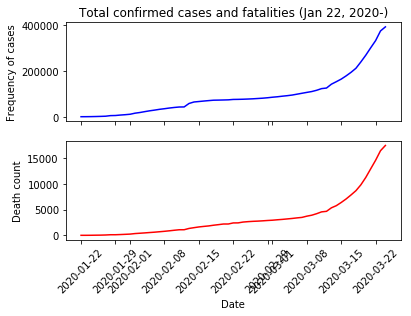

In [11]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(train.groupby('date')['ConfirmedCases'].sum(),color='blue')
ax[1].plot(train.groupby('date')['Fatalities'].agg(sum),color='red')

ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities (Jan 22, 2020-)')
plt.show()

**Observations**: 

Overall confirmed cases and fatalities increased linearly until March when it started to increase exponentially

In [13]:
china_cases     = train[train['place'].str.contains('China')][['date',
                                                               'ConfirmedCases',
                                                               'Fatalities']].reset_index(drop=True)
restworld_cases = train[-train['place'].str.contains('China')][['date',
                                                                'ConfirmedCases',
                                                                'Fatalities']].reset_index(drop=True)

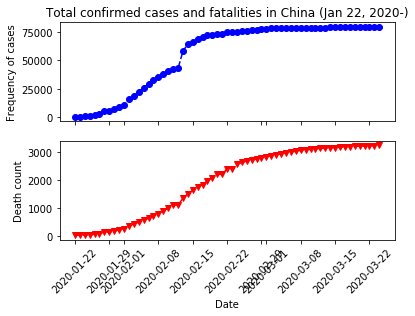

In [14]:
# plot total confirmed cases and fatalities in China (Jan 22-Mar 22, 2020)

fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(china_cases.groupby('date')['ConfirmedCases'].sum(), marker='o',color='b', 
            linestyle='--')
ax[1].plot(china_cases.groupby('date')['Fatalities'].sum(), marker='v',color='r',
            linestyle='--')
ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities in China (Jan 22, 2020-)')
plt.show()

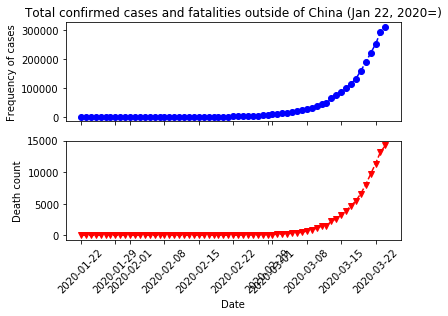

In [16]:
# plot total confirmed cases and fatalities outside of China (Jan 22-Mar 22, 2020)

fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(restworld_cases.groupby('date')['ConfirmedCases'].sum(), marker='o',color='b', 
            linestyle='--')
ax[1].plot(restworld_cases.groupby('date')['Fatalities'].sum(), marker='v',color='r',
            linestyle='--')
ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities outside of China (Jan 22, 2020=)')
plt.show()

**Observation**: 

1. China cases peaked around 15 Feb 2020 and slowed down after. 
2. Rest of the world increaesd in its cases and deaths since 8 March 2020.

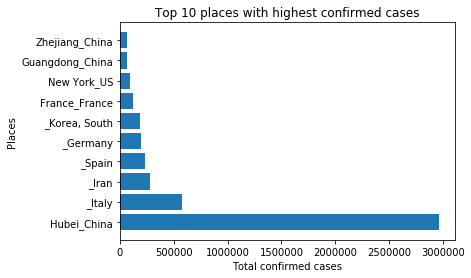

In [17]:
top10cases = train.groupby('place')['ConfirmedCases'].sum().sort_values(ascending=False).head(10)

plt.barh(top10cases.index, top10cases)
plt.ylabel('Places')
plt.xlabel('Total confirmed cases')
plt.title('Top 10 places with highest confirmed cases')
plt.show()

**Observation for above chart**: 

Top 10 places with highest confirmed cases are in China, Italy, Iran, Germany, South Korea, France, New York, Guangdong and Zhejiang in China

In [18]:
# let's look at US states

us_cases     = train[train['place'].str.contains('US')][['date','place',
                                                         'ConfirmedCases',
                                                               'Fatalities']].reset_index(drop=True)

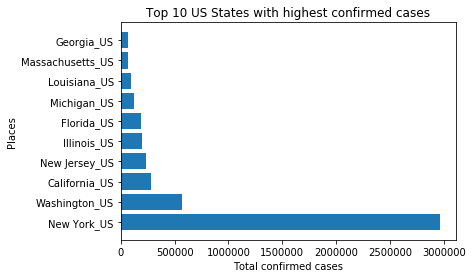

In [19]:
top10uscases = us_cases.groupby('place')['ConfirmedCases'].sum().sort_values(ascending=False).head(10)

plt.barh(top10uscases.index, top10cases)
plt.ylabel('Places')
plt.xlabel('Total confirmed cases')
plt.title('Top 10 US States with highest confirmed cases')
plt.show()

**Observation for above chart**:

Top 3 US states on confirmed cases are New York, Washington, California

## Forecasting process

### Evaluation metric: Root mean squared logarithmic error

In [20]:
def RMSLE(predicted, actual):
    return np.sqrt(np.mean(np.power((np.log(predicted+1)-np.log(actual+1)),2)))

### Checking stationary

In [11]:
train_sub = train[['id','place','date','ConfirmedCases','Fatalities']] 
train_sub['logConfirmedCases'] = np.log(train_sub['ConfirmedCases'])
train_sub = train_sub.set_index('date')

#### Plotting rolling statistics

Plotting rolling means and variances is a first good way to visually inspect our series. If
the rolling statistics exhibit a clear trend (upwards or downwards) and show varying
variance (increasing or decreasing amplitude), then you might conclude that the series
is very likely not to be stationary.

In [12]:
list= []
# using rolling window = 3 days

for place in train_sub.place.unique():    
    a = train_sub[train_sub['place']==place]
    a['z_cases'] = (a['logConfirmedCases']- a['logConfirmedCases'].rolling(window=3).mean())/a['logConfirmedCases'].rolling(window=3).std()
    a['zp_cases']= a['z_cases']- a['z_cases'].shift(3)
    a['z_death'] =(a['Fatalities']-a['Fatalities'].rolling(window=3).mean())/a['Fatalities'].rolling(window=3).std()
    a['zp_death']= a['z_death']- a['z_death'].shift(3)
    list.append(a)
    
rolling_df = pd.concat(list)

In [20]:
def plot_rolling(df, variable, z, zp):
    fit, ax= plt.subplots(2, figsize=(10,9), sharex=True)
    ax[0].plot(df.index, df[variable], label='raw data')
    ax[0].plot(df[variable].rolling(window=3).mean(), label="rolling mean");
    ax[0].plot(df[variable].rolling(window=3).std(), label="rolling std (x10)");
    ax[0].legend()
    
    ax[1].plot(df.index, df[z], label="de-trended data")
    ax[1].plot(df[z].rolling(window=3).mean(), label="rolling mean");
    ax[1].plot(df[z].rolling(window=3).std(), label="rolling std (x10)");
    ax[1].legend()
    
    ax[1].set_xlabel('Date')
    plt.xticks(rotation=45)
    ax[0].set_title('{}'.format(place))
    
    plt.show()
    plt.close()

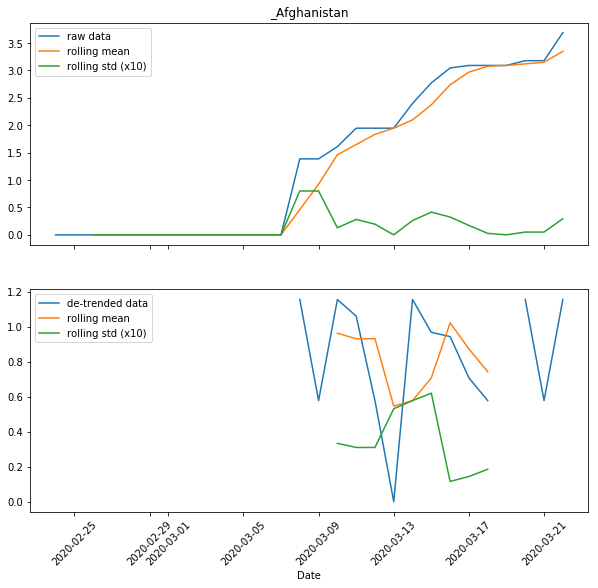

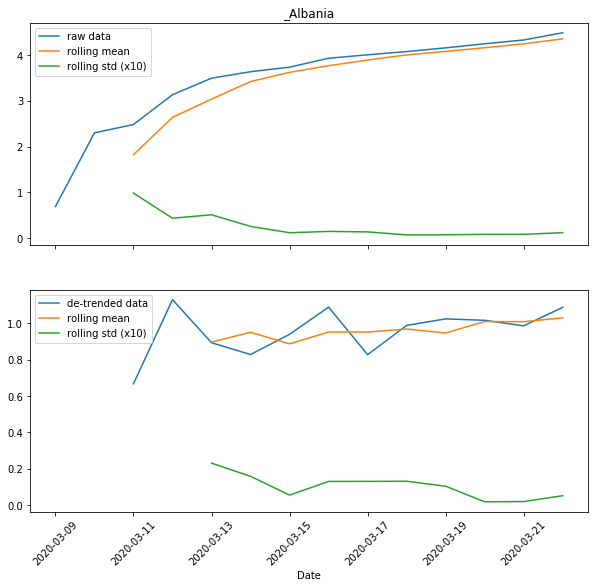

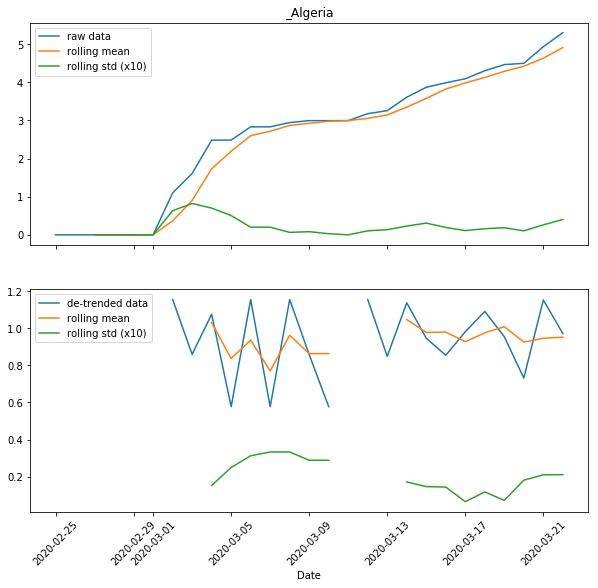

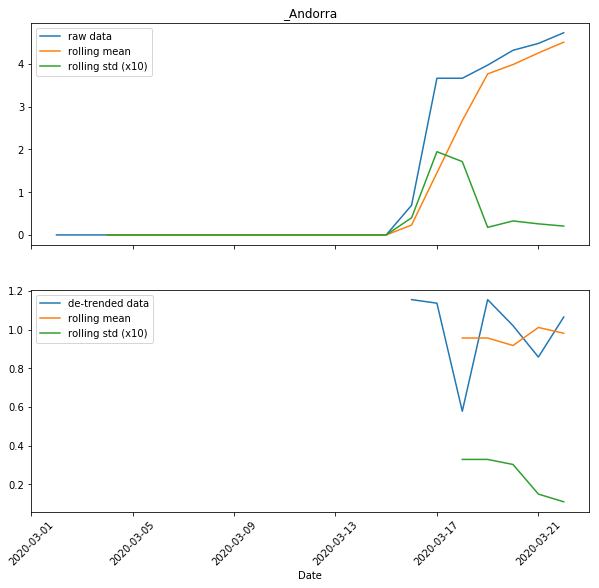

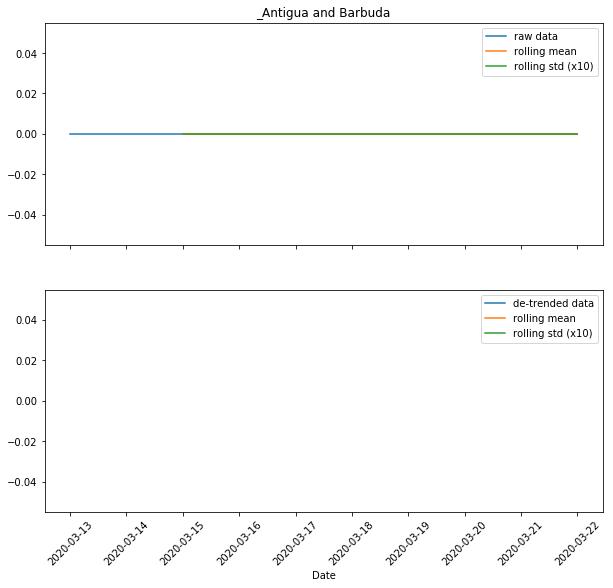

In [39]:
# rolling plots for Confirmed Cases

for place in rolling_df.place.unique()[:5]:
    plot_rolling(df= rolling_df[rolling_df['place']==place], 
                 variable='logConfirmedCases', z= 'z_cases', 
                                 zp= 'zp_cases')

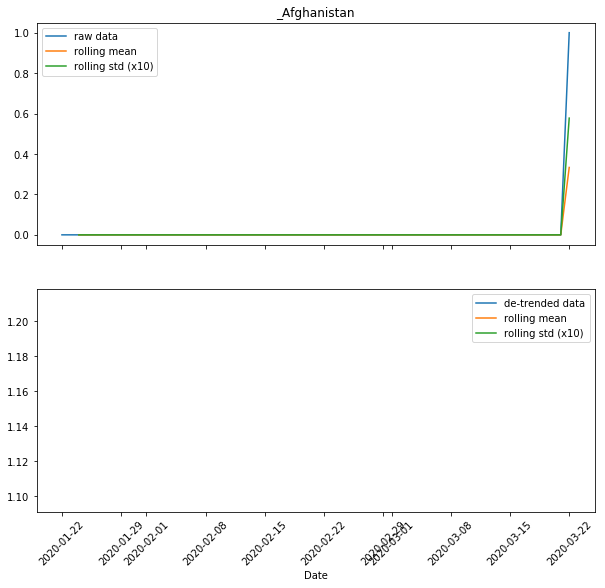

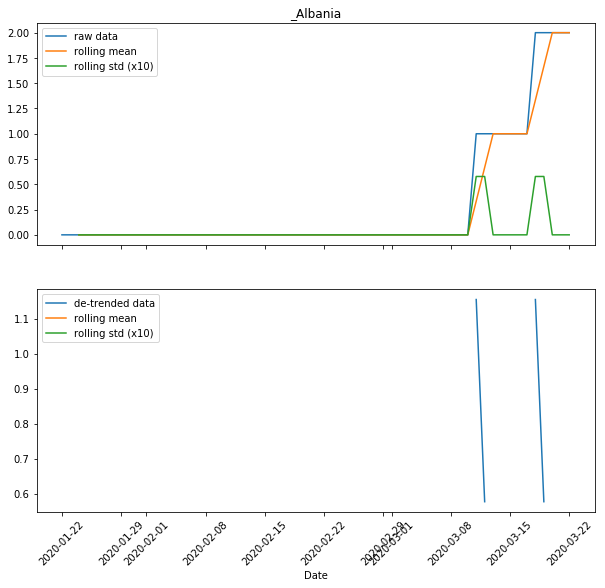

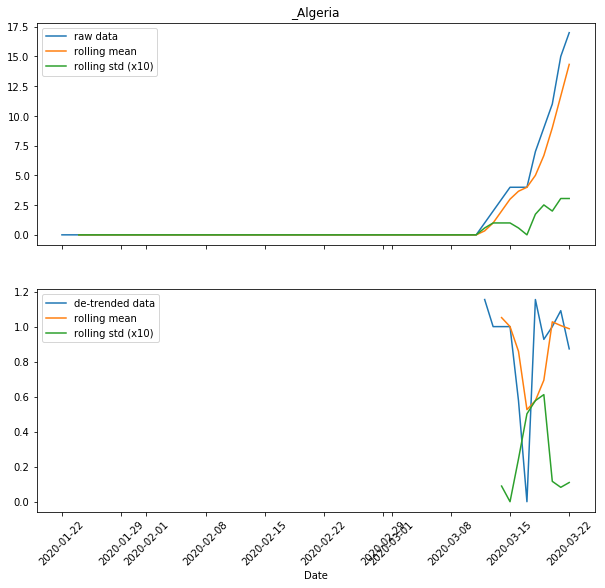

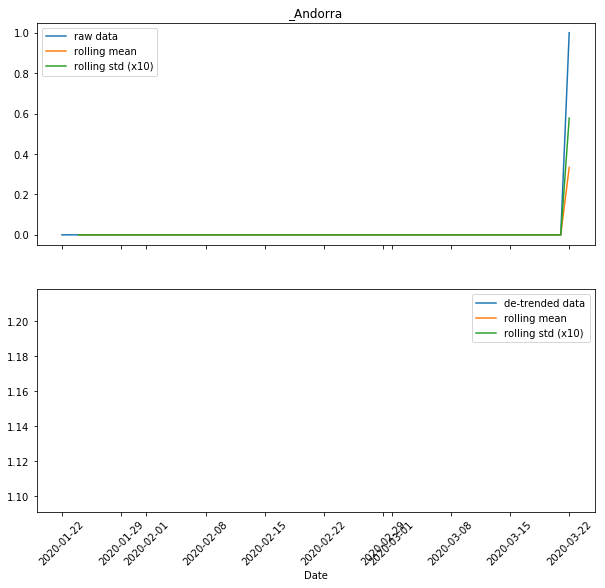

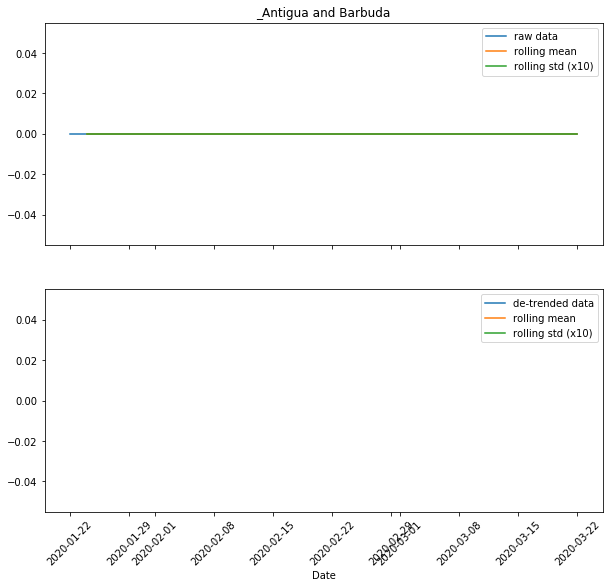

In [43]:
# rolling plots for Fatalities

for place in rolling_df.place.unique()[:5]:
    plot_rolling(df= rolling_df[rolling_df['place']==place], 
                 variable='Fatalities', z= 'z_death', 
                                 zp= 'zp_death')

Rolling mean plots for first 5 places show that data for those places are not so stationary. There is no clear pattern as the increase of cases happen around March 2020 only (lack of data).

#### Apply augmented dickey-fuller test

Null hypothesis that a unit root is present in a time series sample. 
Alternative hypothesis means time series is stationary.

**Test on Confirmed Cases data**

In [13]:
stationary_data =[]
for place in train_sub.place.unique():
    a= rolling_df[(rolling_df['place']==place) & (rolling_df['logConfirmedCases'] > 0)]['logConfirmedCases'].dropna()
    try:   
        dftest = adfuller(a, autolag='AIC')
        if (dftest[1] < 0.001):
            stationary_data.append(place)
        else: 
            pass
    except:
        pass
    
print(len(stationary_data))

38


About 38 places have stationary time series

In [52]:
# list of places with stationary data
print(stationary_data)

['From Diamond Princess_Australia', '_Bosnia and Herzegovina', '_Brunei', '_Burkina Faso', 'New Brunswick_Canada', 'Quebec_Canada', 'Anhui_China', 'Chongqing_China', 'Gansu_China', 'Guangdong_China', 'Guizhou_China', 'Hainan_China', 'Hebei_China', 'Hubei_China', 'Jilin_China', 'Ningxia_China', 'Qinghai_China', 'Shandong_China', 'Shanxi_China', 'Sichuan_China', 'Diamond Princess_Cruise Ship', 'Denmark_Denmark', '_Equatorial Guinea', 'Guadeloupe_France', '_Honduras', '_Kazakhstan', '_Malta', '_Martinique', '_Moldova', '_Poland', '_Qatar', '_Sweden', '_Turkey', 'Delaware_US', 'Maine_US', 'Minnesota_US', 'Wyoming_US', '_Venezuela']


**Test on Fatalities data**

In [15]:
station_death_data =[]
for place in train_sub.place.unique():
    dftest = adfuller(rolling_df[rolling_df['place']==place]['Fatalities'], autolag='AIC')
    if (dftest[1] < 0.001):
        station_death_data.append(place)
    else: 
        pass
    
print(len(station_death_data))

15


About 15 places have stationary time series

In [27]:
# list of stationary data
print(station_death_data)

['_Bulgaria', 'Denmark_Denmark', '_Germany', '_Iceland', '_Iran', '_Kazakhstan', '_Lebanon', '_Norway', '_Portugal', '_Russia', '_Spain', 'Colorado_US', 'Indiana_US', 'Missouri_US', 'Texas_US']


Testing is not enough. We will need to test autocorrelation

#### Check autocorrelation

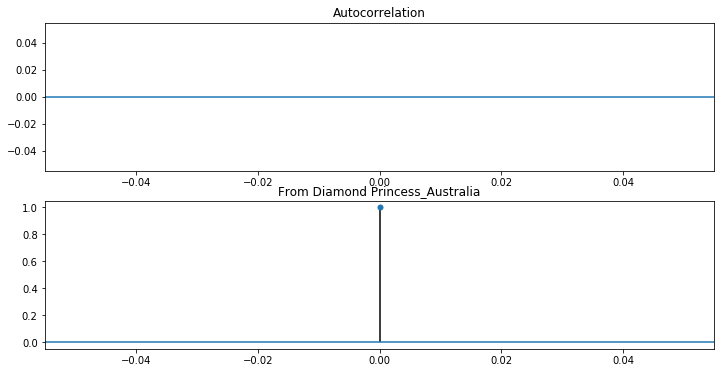

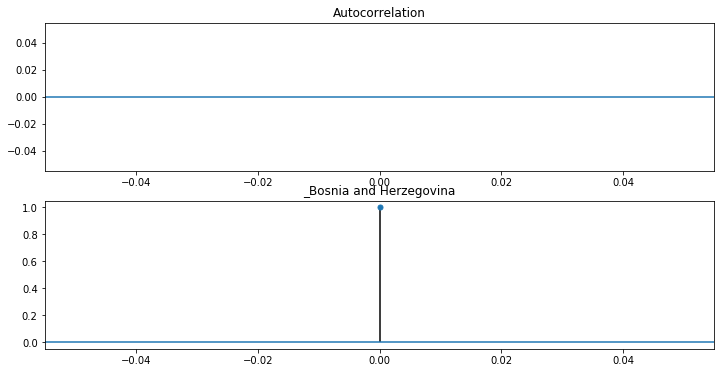

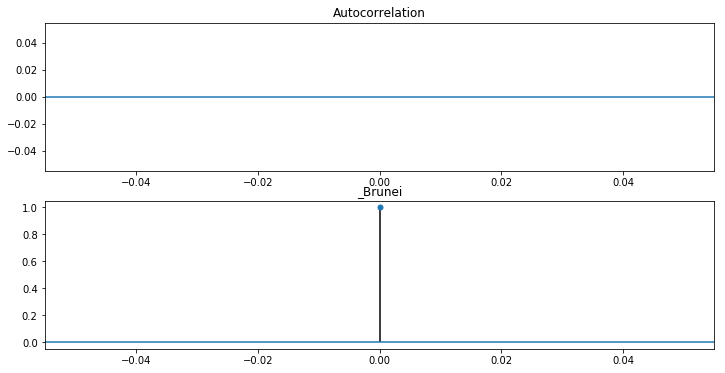

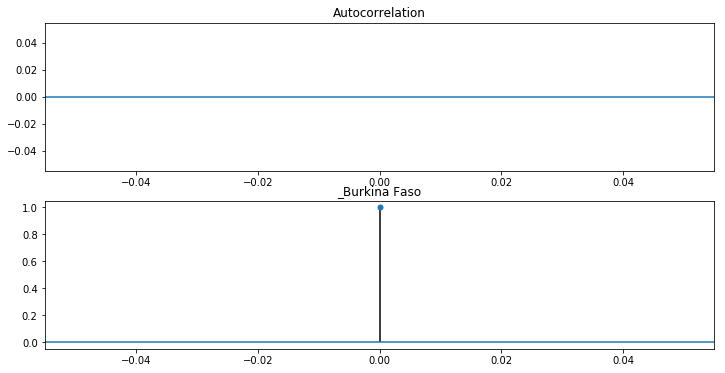

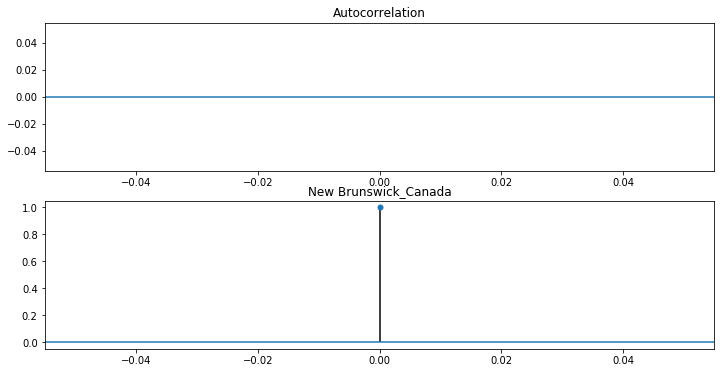

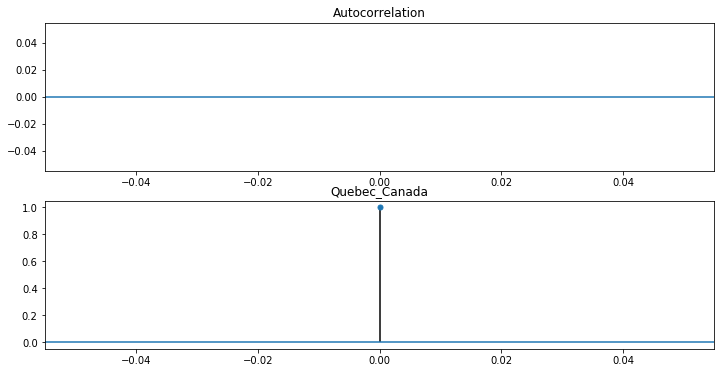

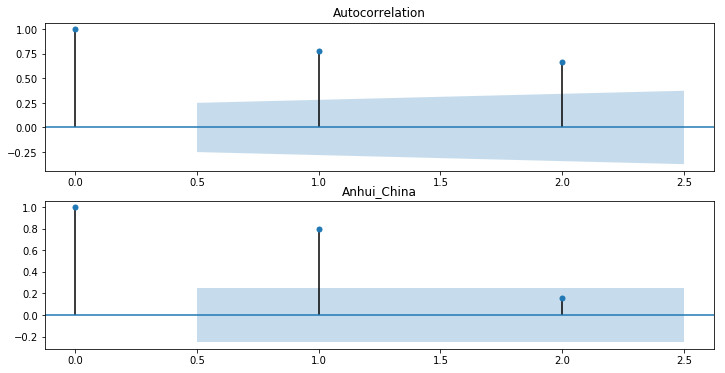

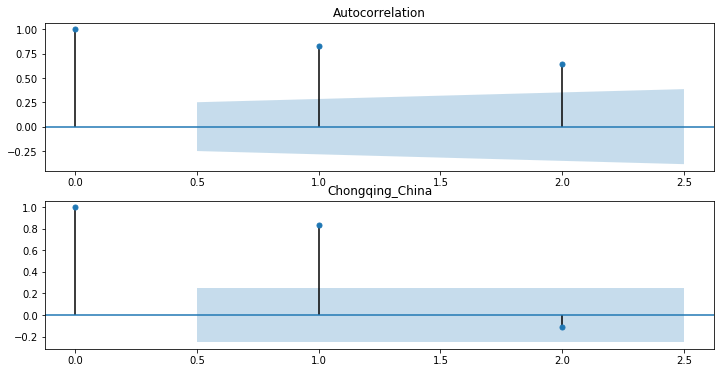

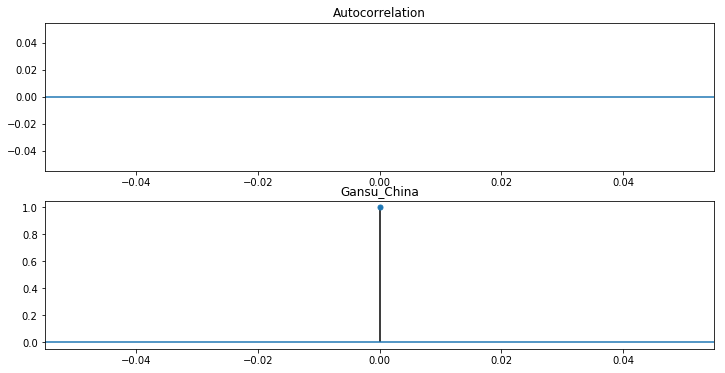

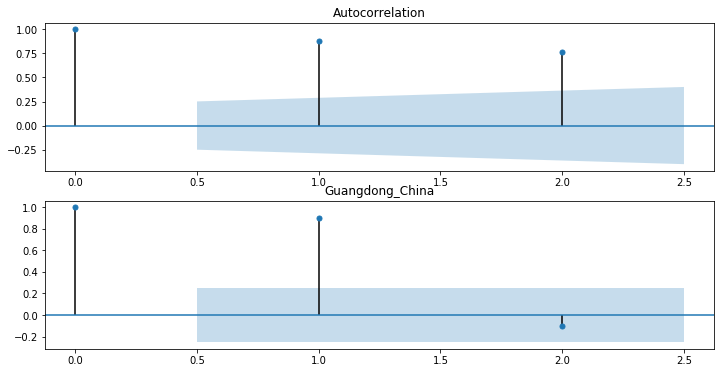

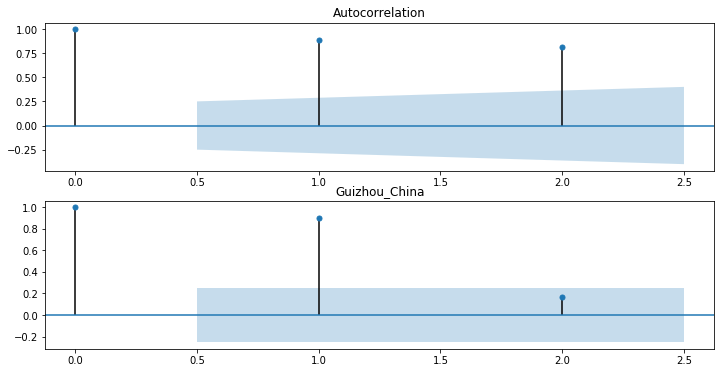

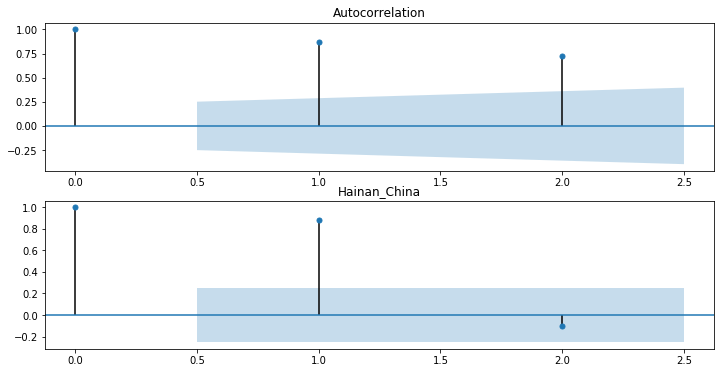

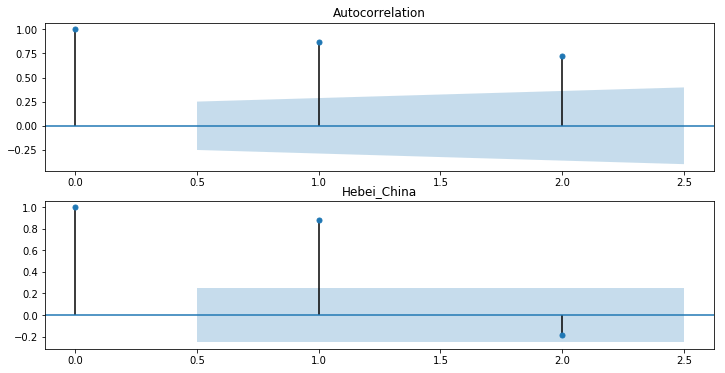

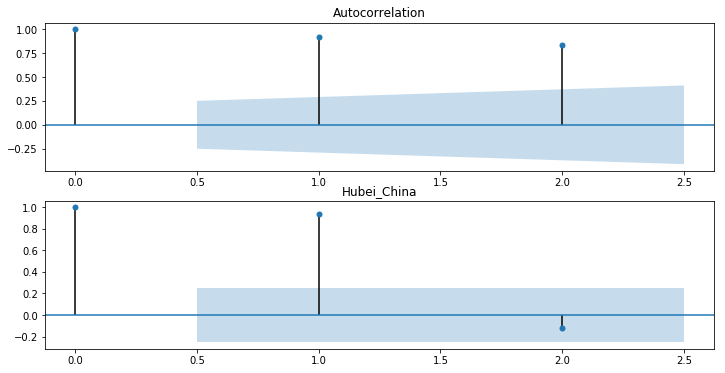

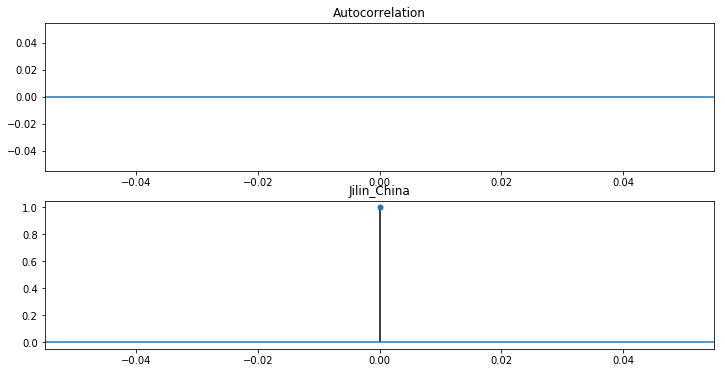

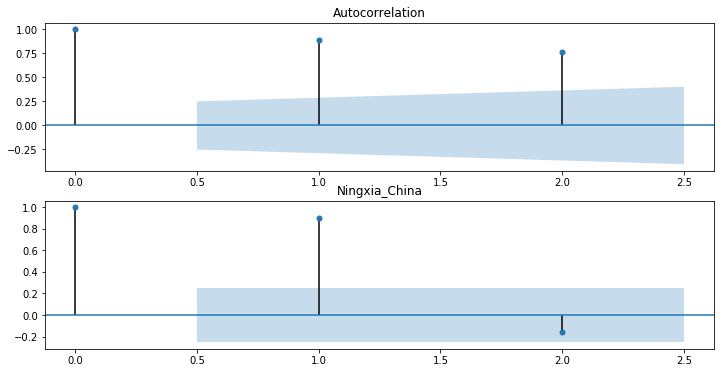

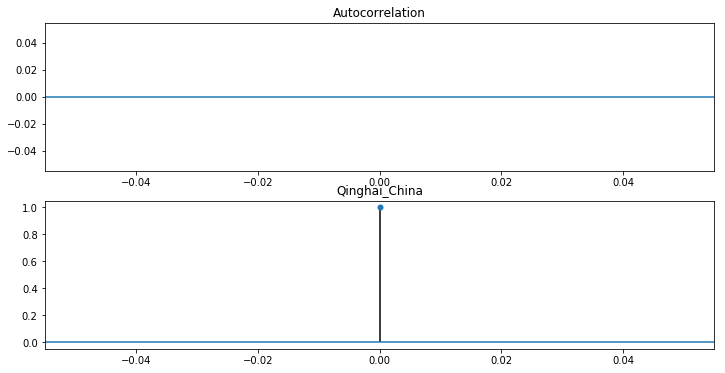

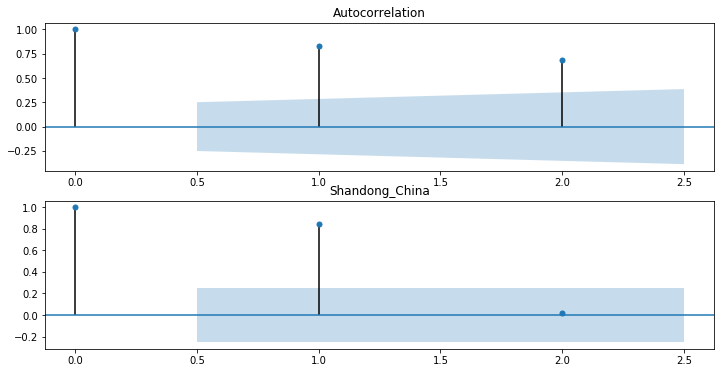

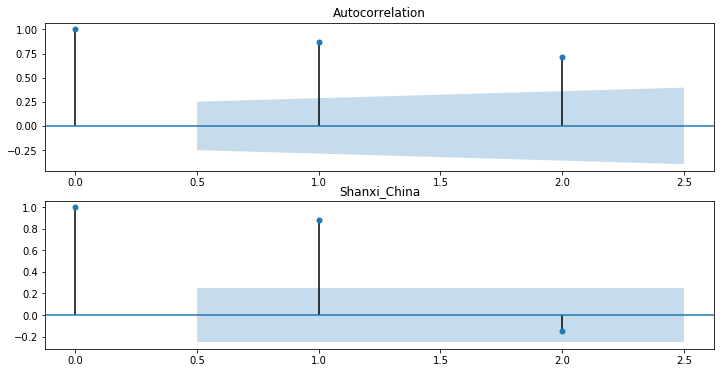

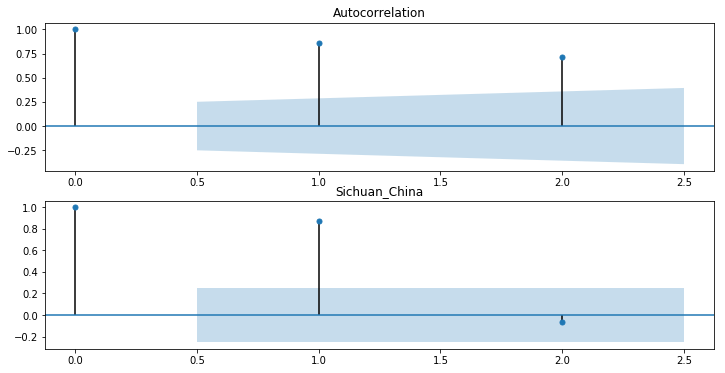

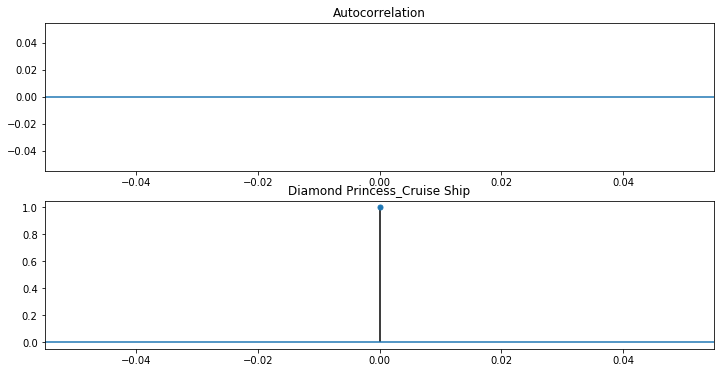

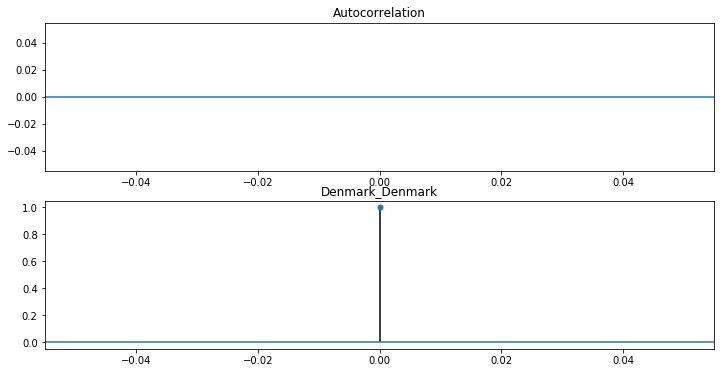

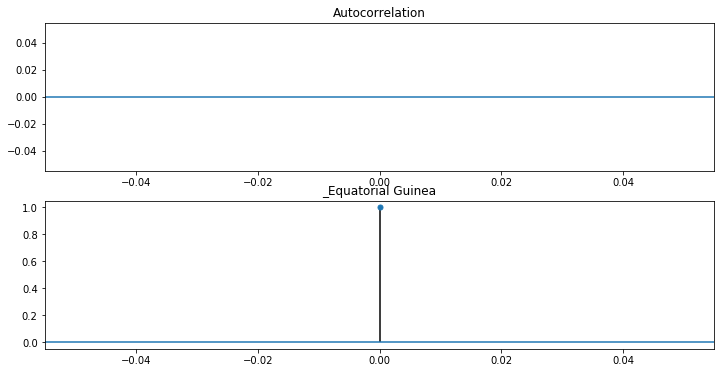

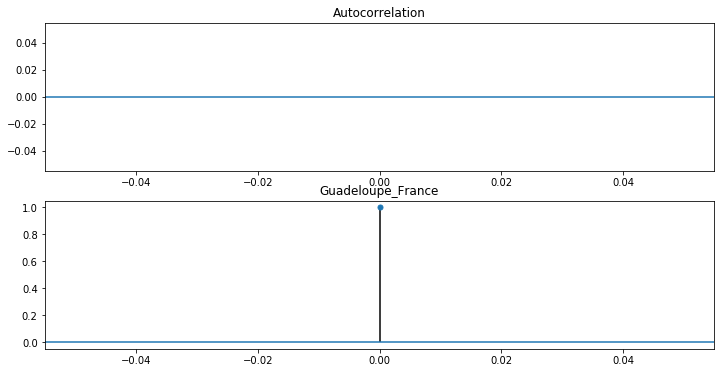

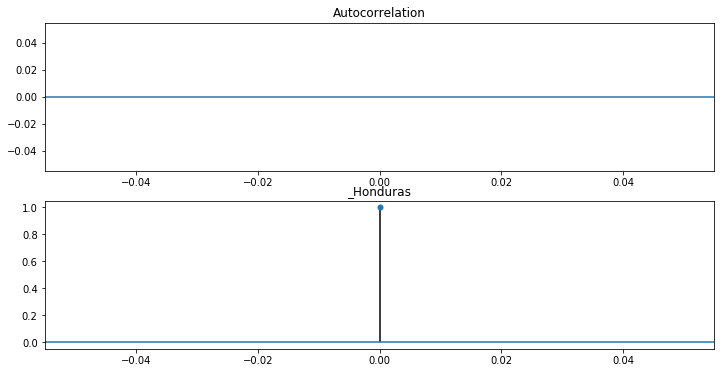

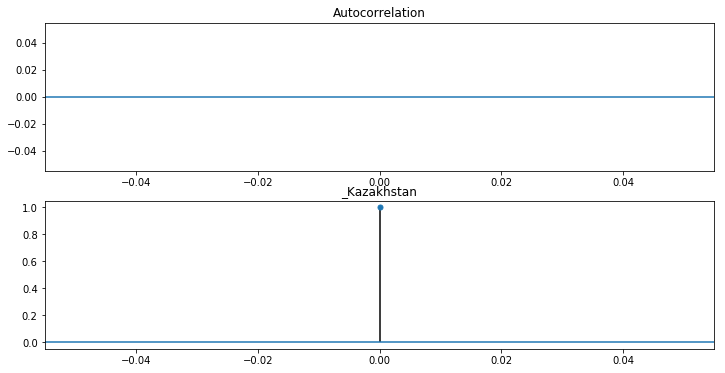

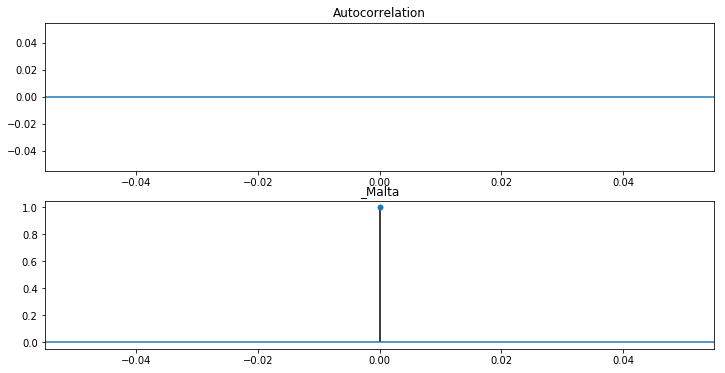

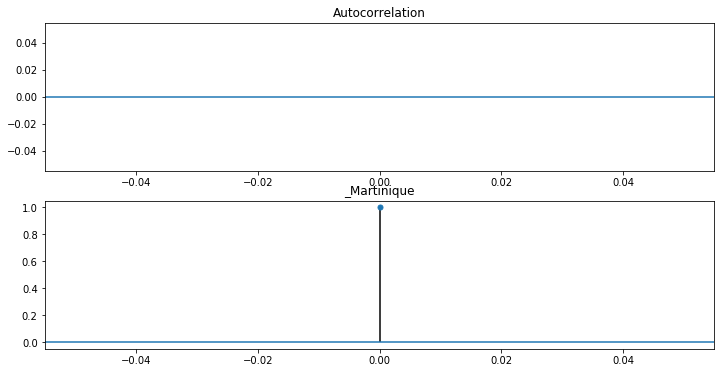

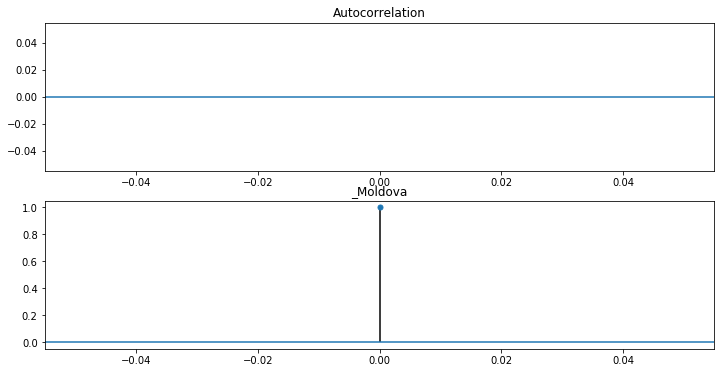

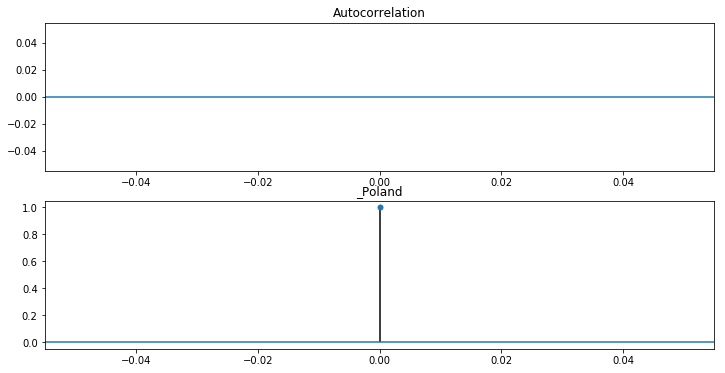

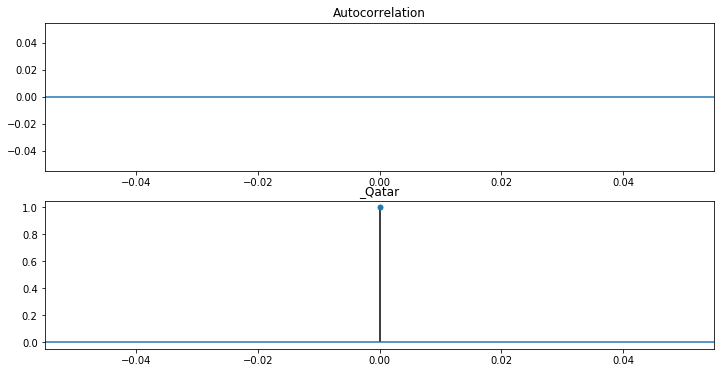

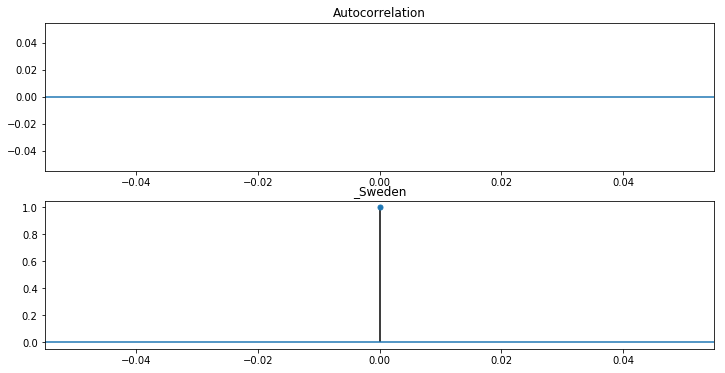

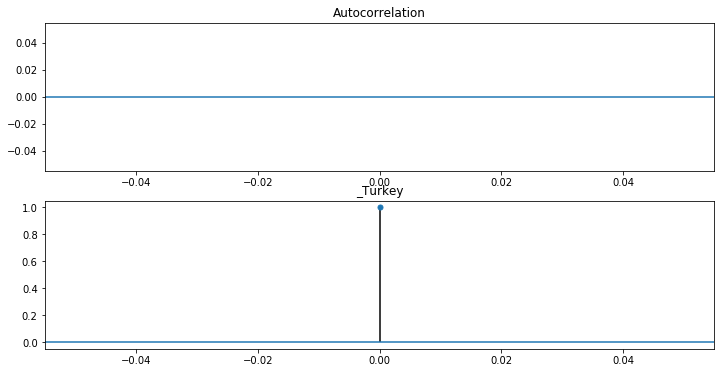

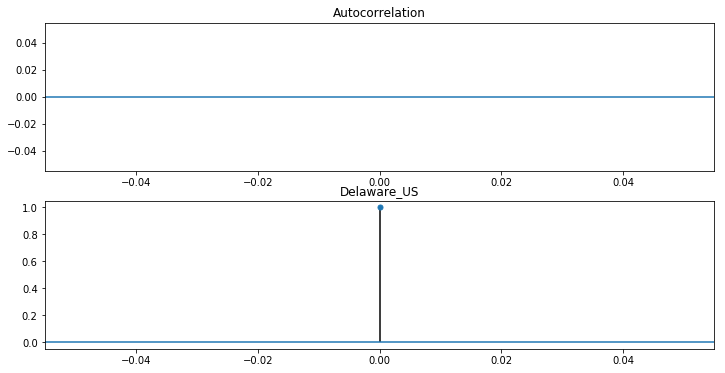

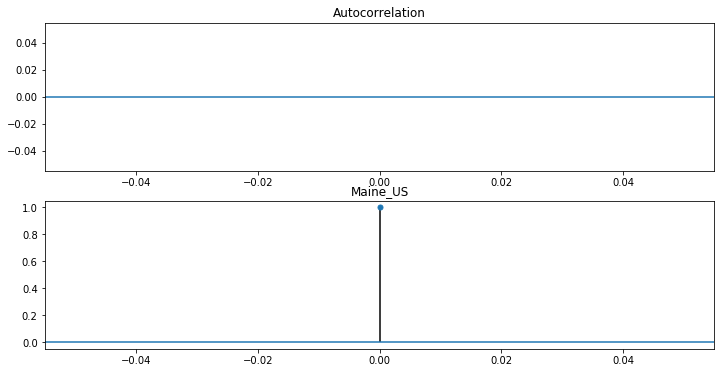

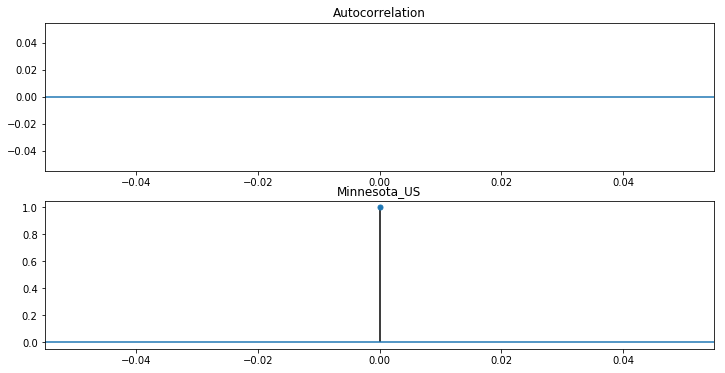

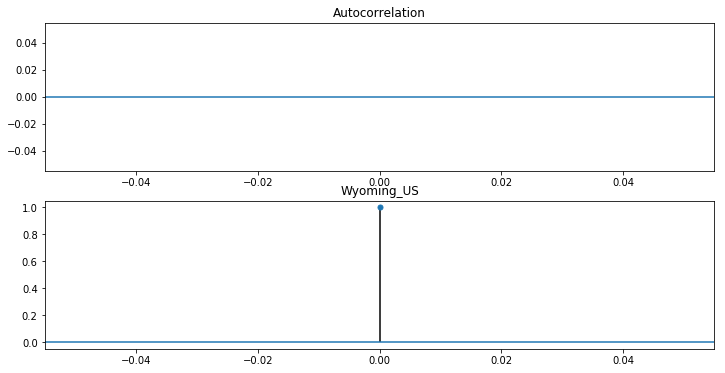

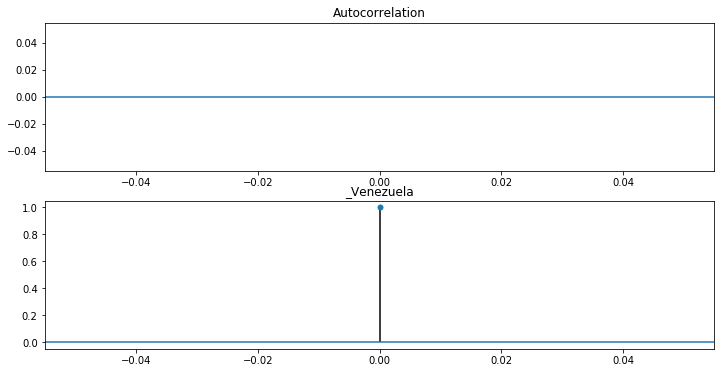

In [106]:
# ACF and PACF plots for Confirmed Cases
for place in stationary_data:
    fig,ax = plt.subplots(2,figsize=(12,6))
    ax[0] = plot_acf(rolling_df[rolling_df['place']==place]['logConfirmedCases'].dropna(), ax=ax[0], lags=2)
    ax[1] = plot_pacf(rolling_df[rolling_df['place']==place]['logConfirmedCases'].dropna(), ax=ax[1], lags=2)
    plt.title('{}'.format(place))

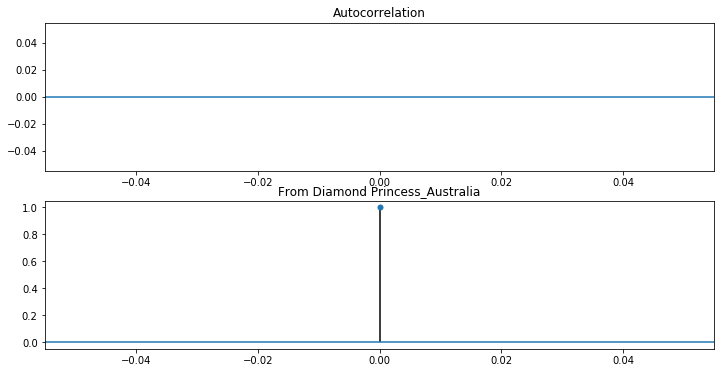

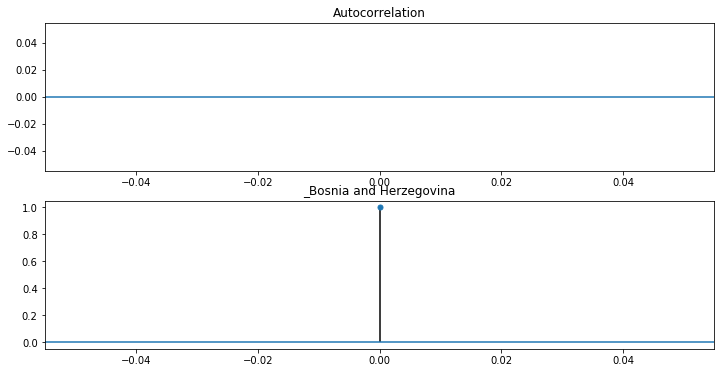

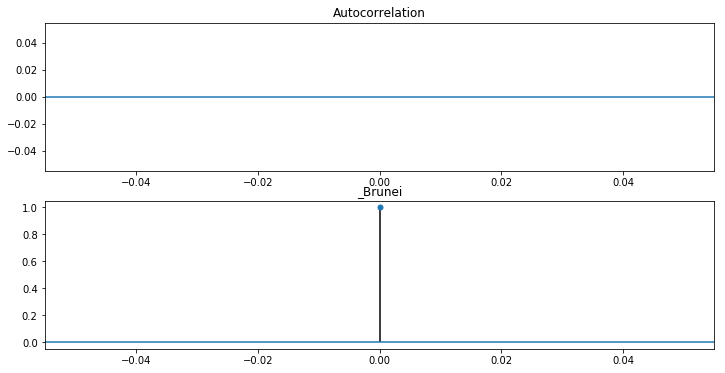

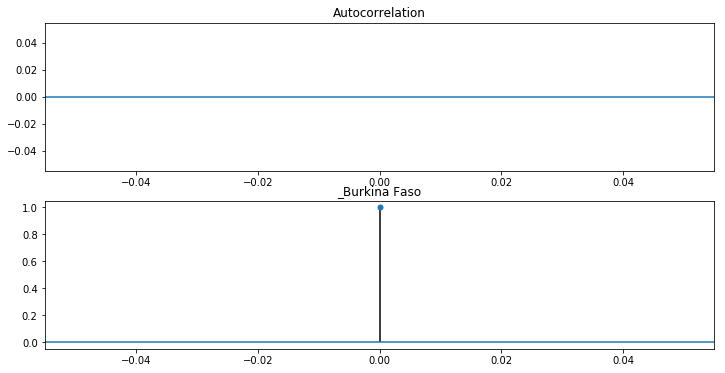

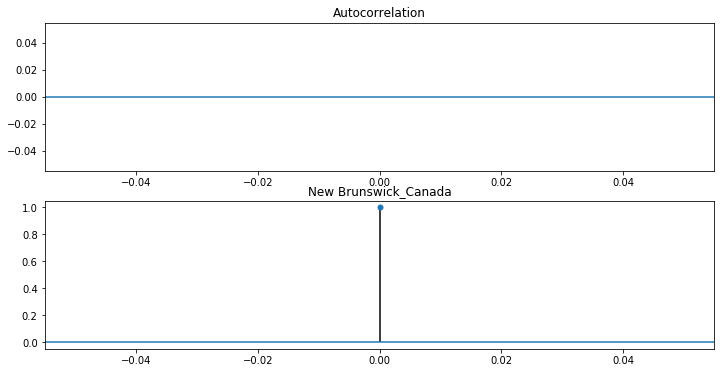

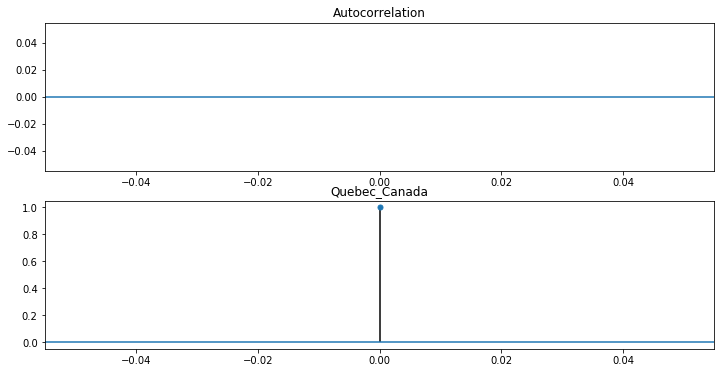

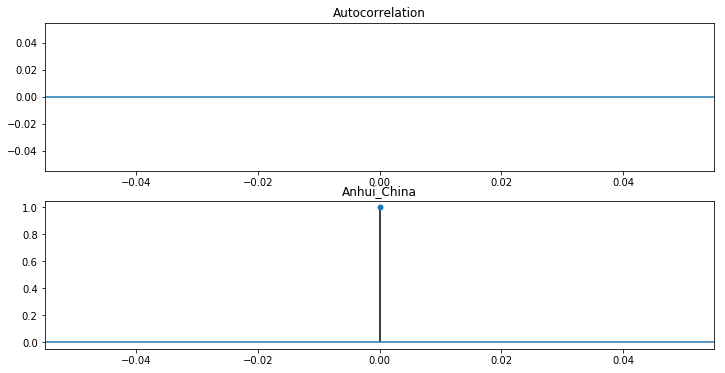

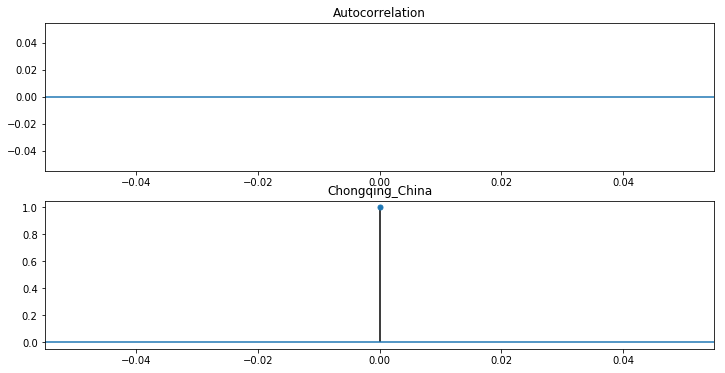

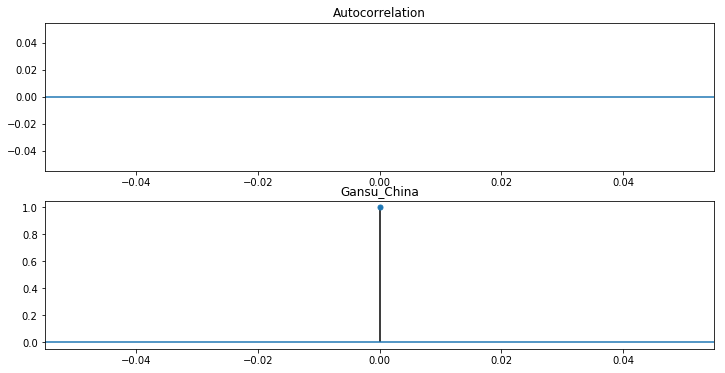

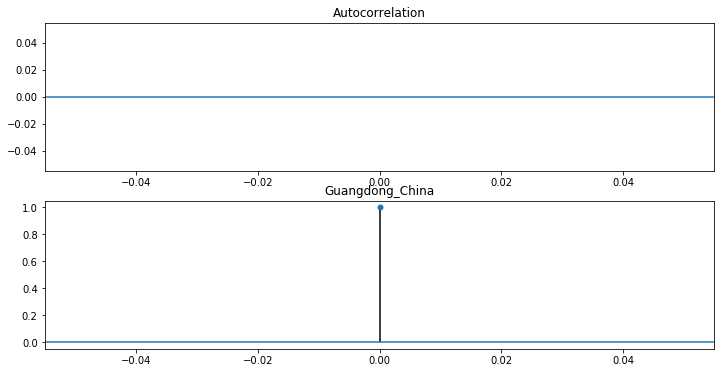

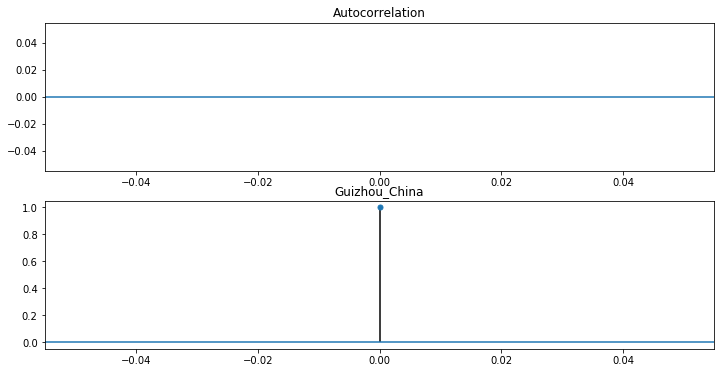

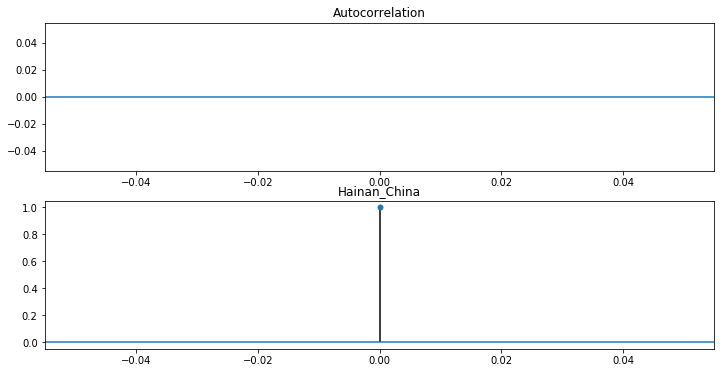

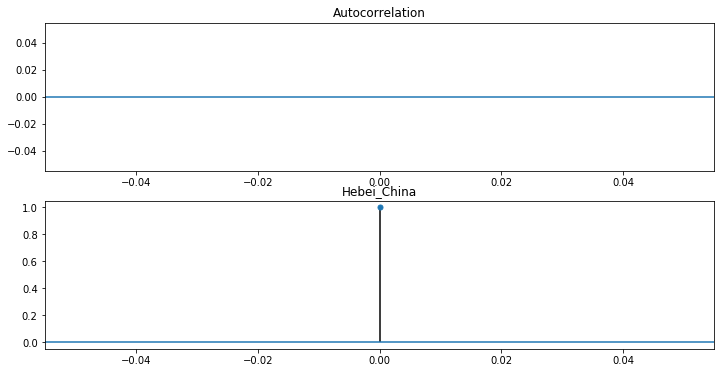

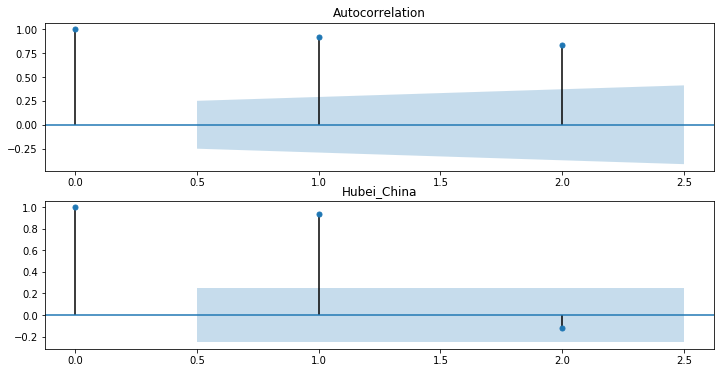

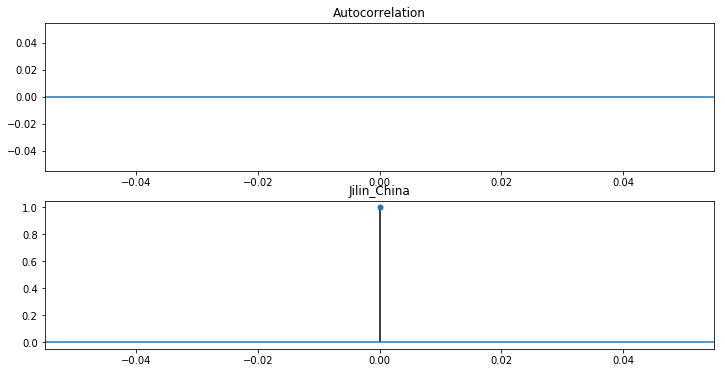

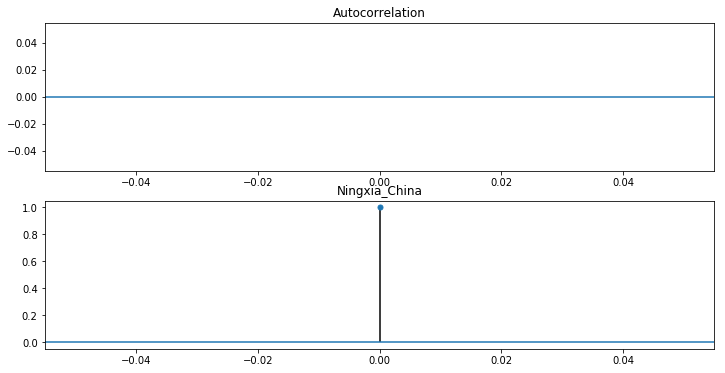

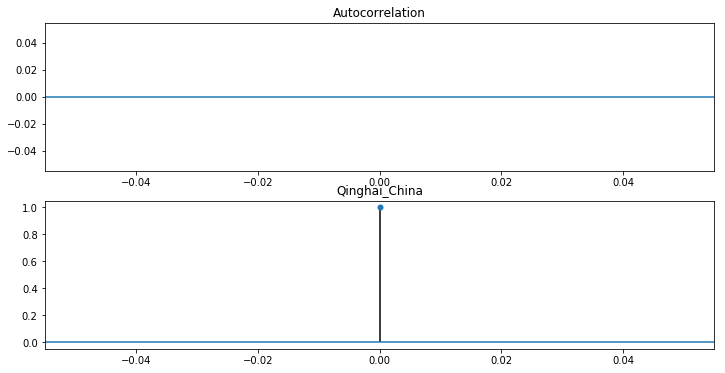

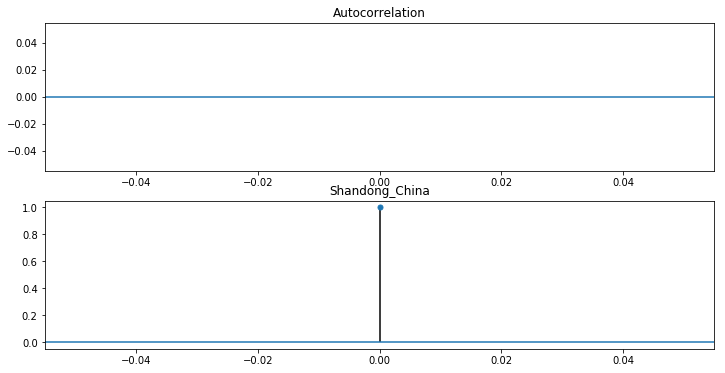

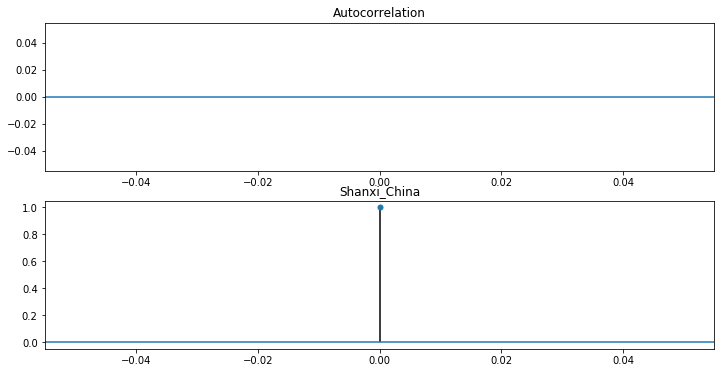

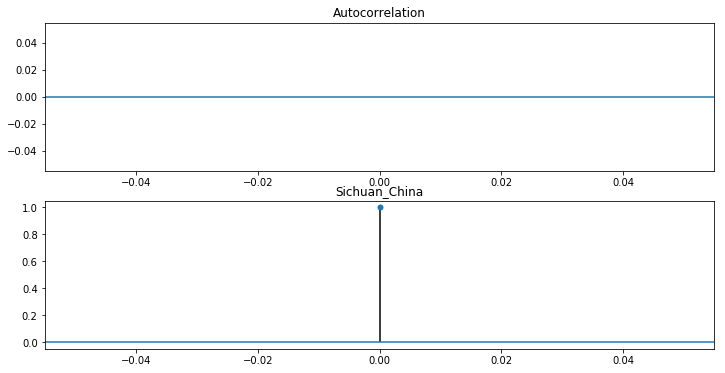

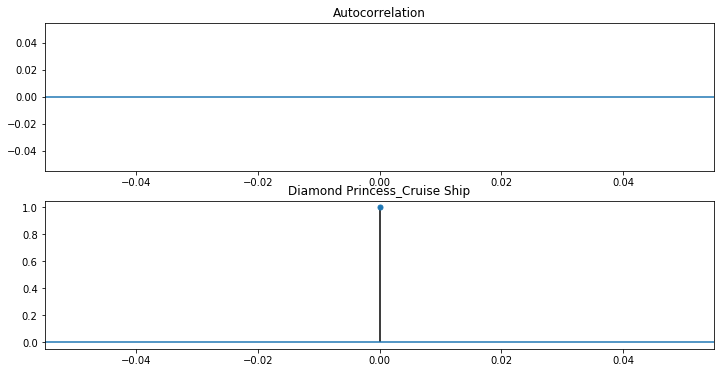

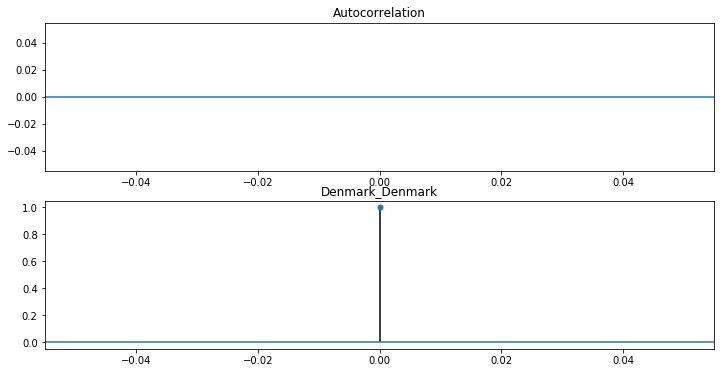

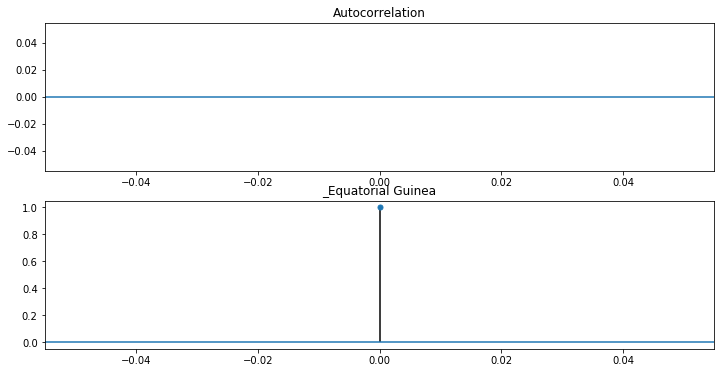

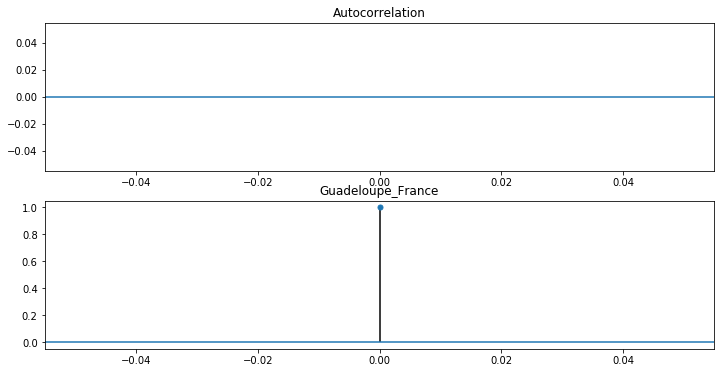

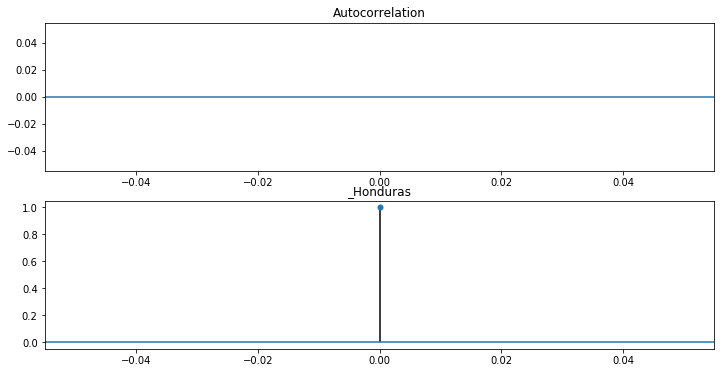

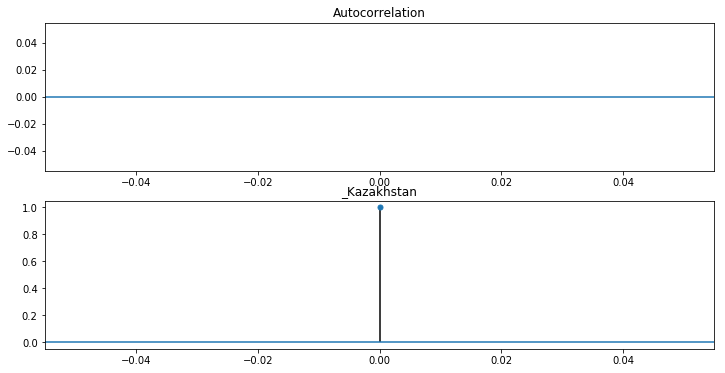

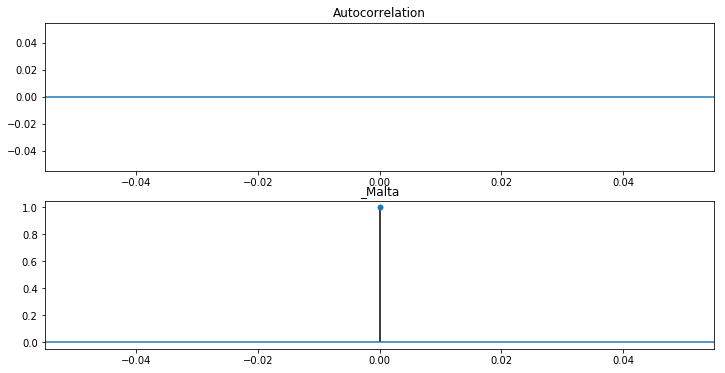

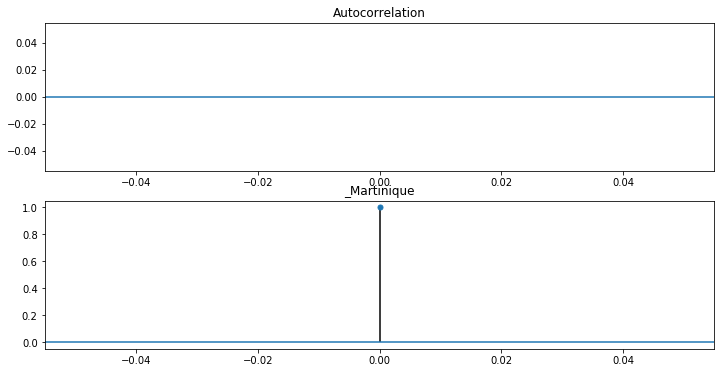

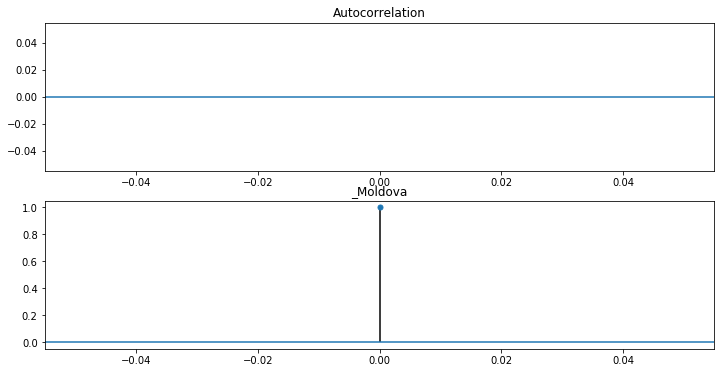

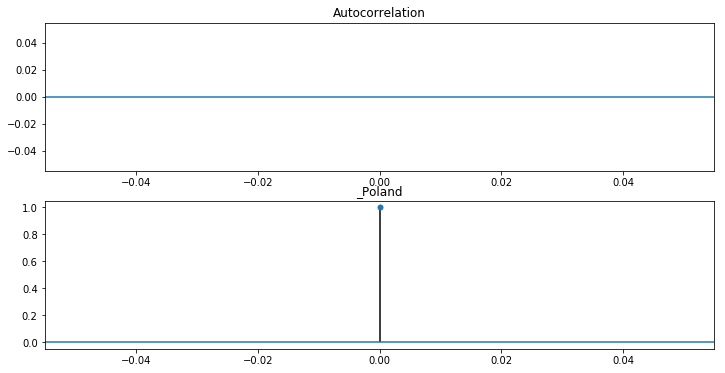

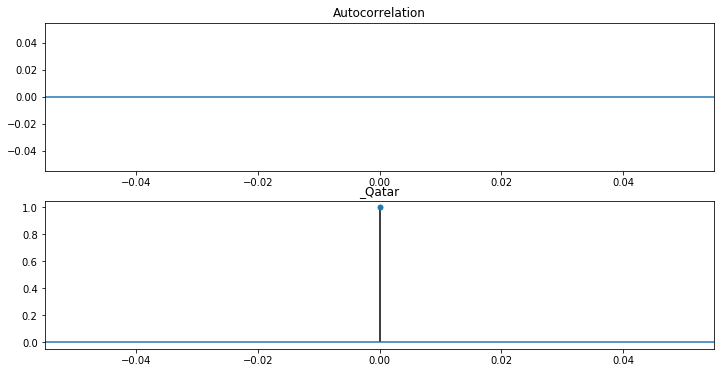

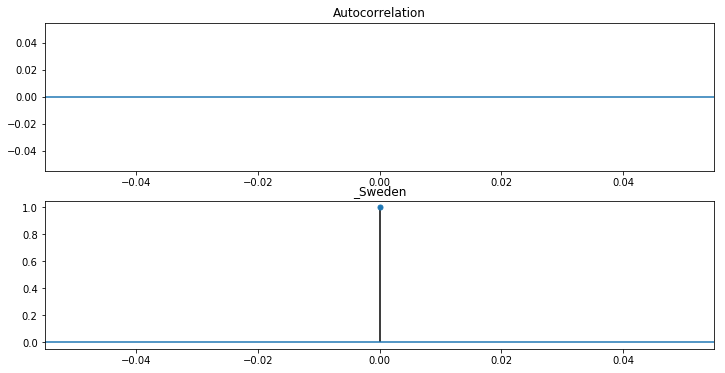

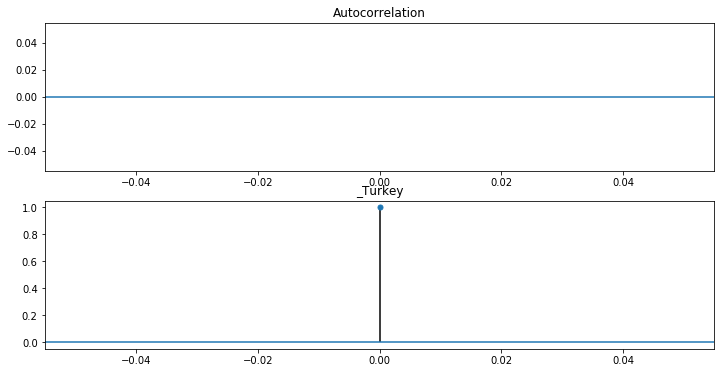

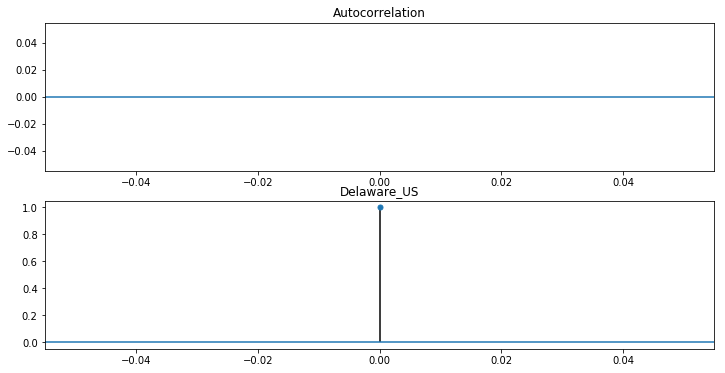

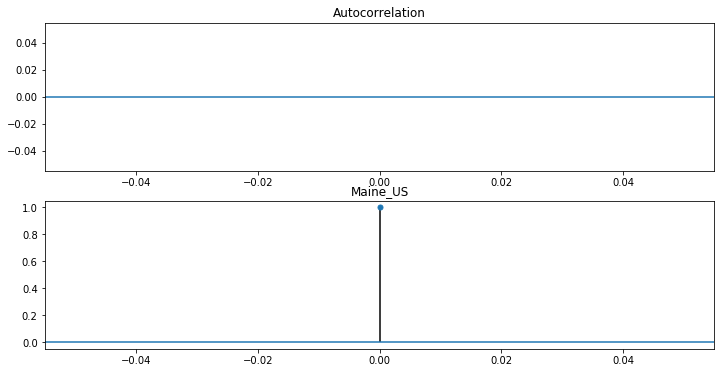

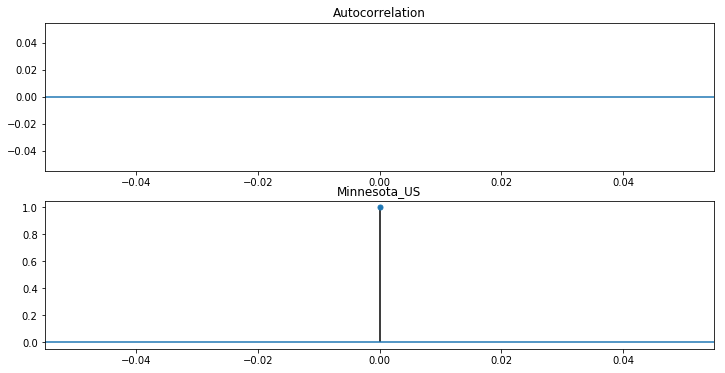

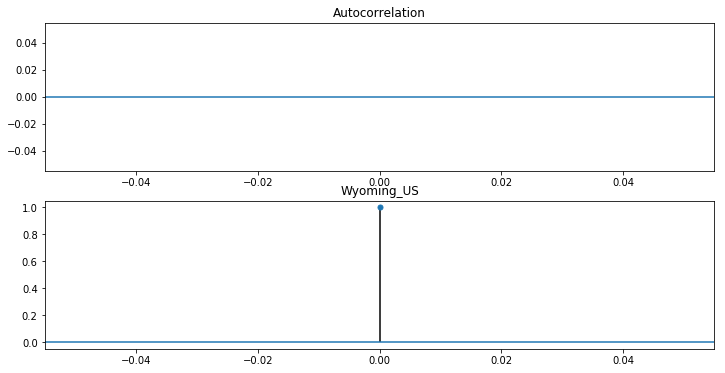

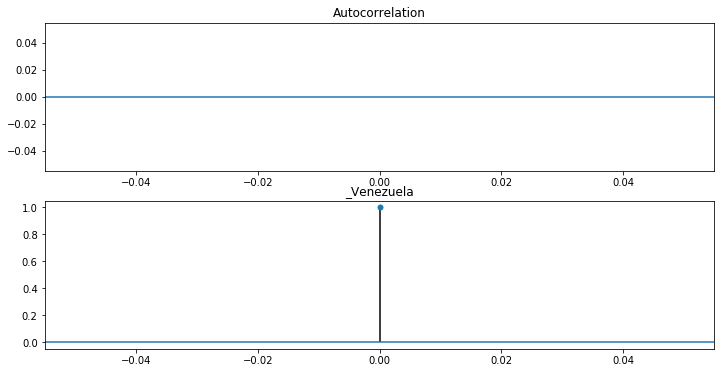

In [105]:
# ACF and PACF plots for Fatalities
for place in stationary_data:
    fig,ax = plt.subplots(2,figsize=(12,6))
    ax[0] = plot_acf(np.log(rolling_df[rolling_df['place']==place]['Fatalities']).dropna(), ax=ax[0], lags=2)
    ax[1] = plot_pacf(np.log(rolling_df[rolling_df['place']==place]['Fatalities']).dropna(), ax=ax[1], lags=2)
    plt.title('{}'.format(place))

There are places with positive spikes above the blue region, meaning there are positive autocorrelations at lag 1 and 2. 

For Confirmed Cases, higher order of differencing is required for:
- Anhui, China; Chongqing, China; Guangdong, China; Guizhou, China; Hainan, China;
- Hebei, China; Hubei, China; Ningxia, China; Shandong, China; Shanxi, China; Sichuan, China

Only, Hubei, China in Fatalities data requires higher order of differencing. 

In [203]:
# list of places with lags for Confirmed Cases
confirmedc_lag = ['Anhui_China', 'Chongqing_China','Guangdong_China',
                  'Guizhou_China', 'Hainan_China', 'Hebei_China','Hubei_China',
                 'Ningxia_China','Shandong_China','Shanxi_China', 'Sichuan_China']

In [205]:
# list of places with non-stationary confirmed cases data
allplaces = train_sub.place.unique().tolist()
non_stationary_data = [ele for ele in allplaces]

for place in confirmedc_lag:
    if place in allplaces:
        non_stationary_data.remove(place)

print(len(non_stationary_data))

273


In [206]:
# list of places with lags for Fatality
fatalities_lag = ['Hubei_China']

In [208]:
# list of places with non-stationary fatalities data
non_stationary_death_data = [ele for ele in allplaces]

for place in fatalities_lag:
    if place in allplaces:
        non_stationary_death_data.remove(place)

print(len(non_stationary_death_data))

283


### Apply exponential smoothing for non-stationary places

Replace neg infinity with zero in logConfirmedCases column

In [210]:
from numpy import inf
train_sub['logConfirmedCases']= train_sub['logConfirmedCases'].replace(to_replace=-inf,
                                                                      value=0)

In [211]:
train_sub.describe()
# to revert log into original values, use math.exp(value)

,id,ConfirmedCases,Fatalities,logConfirmedCases
count,17324.000000,17324.000000,17324.000000,17324.000000
mean,13190.500000,293.191180,10.421208,1.248503
std,7624.680783,3382.665468,155.612328,2.171527
min,1.000000,0.000000,0.000000,0.000000
25%,6595.750000,0.000000,0.000000,0.000000
50%,13190.500000,0.000000,0.000000,0.000000
75%,19785.250000,8.000000,0.000000,2.079442
max,26380.000000,67800.000000,5476.000000,11.124317


#### Find best exponential smoothing for non-stationary ConfirmedCases and Fatalities

In [212]:
# create a function to find best model for the non-stationary ConfirmedCases and Fatalities
def pred_ets(fcastperiod,fcastperiod1,actual,ffcast,variable='ConfirmedCases',verbose=False):
    
    actual=actual[actual[variable]>0]
    index=pd.date_range(start=ffcast.index[0], end=ffcast.index[-1], freq='D')
    data=ffcast[variable].values
    ffcast1 = pd.Series(data, index)
    index=pd.date_range(start=actual.index[0], end=actual.index[-1], freq='D')
    data=actual[variable].values
    daily_analysis_dat = pd.Series(data, index)
    livestock2=daily_analysis_dat
    fit=[]
    fcast=[]
    fname=[]
    try:
        fit1 = SimpleExpSmoothing(livestock2).fit()
        fcast1 = fit1.forecast(fcastperiod1).rename("SES")
        fit.append(fit1)
        fcast.append(fcast1)
        fname.append('SES')
    except:
        1==1
    try:
        fit2 = Holt(livestock2).fit()
        fcast2 = fit2.forecast(fcastperiod1).rename("Holt")
        fit.append(fit2)
        fcast.append(fcast2)
        fname.append('Holt')
    except:
        1==1
    try:
        fit3 = Holt(livestock2, exponential=True).fit()
        fcast3 = fit3.forecast(fcastperiod1).rename("Exponential")
        fit.append(fit3)
        fcast.append(fcast3)
        fname.append('Exponential')
    except:
        1==1
    try:
        fit4 = Holt(livestock2, damped=True).fit(damping_slope=0.98)
        fcast4 = fit4.forecast(fcastperiod1).rename("AdditiveDamped")
        fit.append(fit4)
        fcast.append(fcast4)
        fname.append('AdditiveDamped')
    except:
        1==1
    try:
        fit5 = Holt(livestock2, exponential=True, damped=True).fit()
        fcast5 = fit5.forecast(fcastperiod1).rename("MultiplicativeDamped")
        fit.append(fit5)
        fcast.append(fcast5)
        fname.append('MultiplicativeDamped')
    except:
        1==1
    try:
        fit6 = Holt(livestock2, damped=True).fit()
        fcast6 = fit6.forecast(fcastperiod1).rename("AdditiveDampedC")
        fit.append(fit6)
        fcast.append(fcast6)
        fname.append('AdditiveDampedC')
    except:
        1==1
    
    pred_all_result=pd.concat([pd.DataFrame(k.fittedvalues) for k in fit],axis=1)
    pred_all_result.columns=fname
    all_result=pd.concat([pd.DataFrame(k) for k in fcast],axis=1)
    col_chk=[]
    vvvl=ffcast[variable].values.shape[0]
    for k in all_result.columns:
        if verbose: print("actual value for method %s  is = %s" % (k,
                                                                   RMSLE(all_result[k].values,
                                                                         ffcast[variable].values)))
        if RMSLE(all_result[k].values[:vvvl],ffcast[variable].values) is not np.nan:
            col_chk.append(k)
    col_chk_f=[]
    min_acc=-1
    for k in col_chk:
        acc=RMSLE(pred_all_result[k].values,actual[variable].values)
        # if k =='AdditiveDamped' and acc>0.01:
        # acc=acc-0.01
        if verbose: print("pred value for method %s  is = %s" % (k,acc))
        if acc is not np.nan:
            col_chk_f.append(k)
            if min_acc==-1:
                min_acc=acc
                model_select=k
            elif acc<min_acc:
                min_acc=acc
                model_select=k
    all_result=all_result.append(pred_all_result,sort=False)
    all_result['best_model']=model_select
    all_result['best_pred']=all_result[model_select]
    return all_result

#### Perform forecasting using best model

In [213]:
warnings.filterwarnings("ignore")
import sys
orig_stdout = sys.stdout

Fatalities_all_result_final=pd.DataFrame()
ConfirmedCases_all_result_Final=pd.DataFrame()
for keys in non_stationary_data:
    chk=train[train['place']==keys]
    chk.index=chk.date
    fcastperiod=0
    fcastperiod1=35
    actual=chk[:chk.shape[0]-fcastperiod]
    ffcast=chk[chk.shape[0]-fcastperiod-1:]
    ffcast
    try:
        Fatalities_all_result_1=pred_ets(fcastperiod,fcastperiod1,actual,
                                         ffcast,'Fatalities').reset_index()
        
    except:
        Fatalities_all_result_1=pd.DataFrame(pd.date_range(start=chk.date.min(), 
                                                           periods=60+fcastperiod1+1, 
                                                           freq='D')[1:])
        Fatalities_all_result_1.columns=['index']
        Fatalities_all_result_1['best_model']='naive'
        Fatalities_all_result_1['best_pred']=0
        
    Fatalities_all_result_1['place']=keys
    Fatalities_all_result_final=Fatalities_all_result_final.append(Fatalities_all_result_1,
                                                                   sort=True)
    try:
        ConfirmedCases_all_result_1=pred_ets(fcastperiod,fcastperiod1,actual,
                                             ffcast,'ConfirmedCases').reset_index()

    except:
        ConfirmedCases_all_result_1=pd.DataFrame(pd.date_range(start=train.date.min(), 
                                                               periods=60+fcastperiod1+1, 
                                                               freq='D')[1:])
        ConfirmedCases_all_result_1.columns=['index']
        ConfirmedCases_all_result_1['best_model']='naive'
        ConfirmedCases_all_result_1['best_pred']=1
    
    ConfirmedCases_all_result_1['place']=keys
    ConfirmedCases_all_result_Final=ConfirmedCases_all_result_Final.append(ConfirmedCases_all_result_1,sort=True)
print(' done')

sys.stdout = orig_stdout

 done


In [214]:
# place with lack of data to forecast
print(Fatalities_all_result_1['place'].unique())
print(ConfirmedCases_all_result_1['place'].unique())

['_Zambia']
['_Zambia']


In [215]:
print(Fatalities_all_result_final.columns)
print(ConfirmedCases_all_result_Final.columns)

Index(['AdditiveDamped', 'AdditiveDampedC', 'Exponential', 'Holt',
       'MultiplicativeDamped', 'SES', 'best_model', 'best_pred', 'index',
       'place'],
      dtype='object')
Index(['AdditiveDamped', 'AdditiveDampedC', 'Exponential', 'Holt',
       'MultiplicativeDamped', 'SES', 'best_model', 'best_pred', 'index',
       'place'],
      dtype='object')


#### Best model used for each place's ConfirmedCases and Fatalities

For Confirmed Cases

In [216]:
ConfirmedCases_all_result_Final.groupby('best_model')['place'].nunique().sort_values(ascending=False)

best_model
Exponential             73
MultiplicativeDamped    69
Holt                    53
AdditiveDamped          29
naive                   26
AdditiveDampedC         13
SES                     10
Name: place, dtype: int64

For Fatalities

In [217]:
Fatalities_all_result_final.groupby('best_model')['place'].nunique().sort_values(ascending=False)

best_model
naive                   143
Exponential              38
SES                      37
MultiplicativeDamped     24
Holt                     18
AdditiveDampedC          11
AdditiveDamped            2
Name: place, dtype: int64

### Applying ARIMA to places with stationary ConfirmedCases and Fatalities

#### Applying ARIMA to Confirmed Cases

In [271]:
print(confirmedc_lag, fatalities_lag)

['Anhui_China', 'Chongqing_China', 'Guangdong_China', 'Guizhou_China', 'Hainan_China', 'Hebei_China', 'Hubei_China', 'Ningxia_China', 'Shandong_China', 'Shanxi_China', 'Sichuan_China'] ['Hubei_China']


Order in ARIMA function refers to the (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

P — Auto regressive feature of the model

D — Differencing order

Q — Moving average feature of the model


Forecasting for 35 days

In [341]:
lagplaces_confirmedc_aic =[]
cc_pred    = pd.DataFrame()

for place in confirmedc_lag:
    model = ARIMA(rolling_df[rolling_df['place']==place]['logConfirmedCases'].dropna(), 
                  (2,1,0))
    res   = model.fit()
    lagplaces_confirmedc_aic.append(ARMAResults.aic(res))
    pred    = res.forecast(35)
    pred1   = np.exp(pred[1])  #lower bound
    results = pd.DataFrame(pd.date_range(start=train.date.max(), 
                                                               periods=36, freq='D'))[1:]
    results.columns = ['index']
    results['place']=place
    results['best_pred']=pred1
    cc_pred= cc_pred.append(results,sort=True)
    
    print('lag_ConfirmedC_AICs: ', lagplaces_confirmedc_aic)

lag_ConfirmedC_AICs:  [-11.035682115556341]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394, -205.04338986659224]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394, -205.04338986659224, -29.116228179725937]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394, -205.04338986659224, -29.116228179725937, -90.7086724721799]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394, -205.04338986659224, -29.116228179725937, -90.7086724721799, -38.04589650874769]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394, -205.04338986659224, -29.116228179725937, -90.7086724721799, -38.04589650874769, -67.91084763912463]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394, -205.04338986659224, -29.116228179725937, -90.7086724721799, -38.04589650874769, -67.91084763912463, -90.0394640174008]
lag_ConfirmedC_AICs:  [-11.035682115556341, -77.24535052691394, -205.0433898665922

In [327]:
lagplaces_fatality_aic =[]
death_pred    = pd.DataFrame()

for place in fatalities_lag:
    model = ARIMA(np.log(rolling_df[rolling_df['place']==place]['Fatalities'].dropna()),
                  (2,1,0))
    res   = model.fit()
    lagplaces_fatality_aic.append(ARMAResults.aic(res))
    pred    = res.forecast(35)
    pred1   = np.exp(pred[1]) # lower bound
    results = pd.DataFrame(pd.date_range(start=train.date.max(), 
                                                               periods=36, freq='D'))[1:]
    results.columns = ['index']
    results['place']=place
    results['best_pred']=pred1
    death_pred= death_pred.append(results,sort=True)
    
print('lag_Fatalities_AICs: ', lagplaces_fatality_aic)

lag_Fatalities_AICs:  [-107.06172539342134]


For lag data, the lowest AIC is generated from second-order autoregressive model with one order of nonseasonal differencing and a constant term--i.e., an ARIMA(2,1,0) model.

Source: https://people.duke.edu/~rnau/411arim.htm#arima110

**Observations**:

Low AIC values may be overfitting for ARIMA.

### Try implementing Polynomial Regression

In [80]:
poly_data = train[['date','place',
                  'ConfirmedCases','Fatalities']].merge(test[['date','place']], 
                                                      how='outer', 
                                                        on=['date','place']).sort_values(['place',
                                                                                          'date'])

print(poly_data.date.min(), test.date.min(), train.date.max(), poly_data.date.max())

2020-01-22 00:00:00 2020-03-12 00:00:00 2020-03-24 00:00:00 2020-04-23 00:00:00


In [81]:
# create label for each date by each place
label = []
for place in poly_data.place.unique():
    labelrange = range(1,len(poly_data[poly_data['place']==place])+1)
    label.append([i for i in labelrange])
lab = [item for lab in label for item in lab]
poly_data['label'] = lab
poly_data.head()

,date,place,ConfirmedCases,Fatalities,label
13482,2020-01-22,Alabama_US,0.0,0.0,1
13483,2020-01-23,Alabama_US,0.0,0.0,2
13484,2020-01-24,Alabama_US,0.0,0.0,3
13485,2020-01-25,Alabama_US,0.0,0.0,4
13486,2020-01-26,Alabama_US,0.0,0.0,5


In [86]:
XYtrain = poly_data[(poly_data['date']>'2020-01-21')&((poly_data['date']<'2020-03-25'))]
print(XYtrain.date.min(), XYtrain.date.max(), XYtrain.isna().sum())

2020-01-22 00:00:00 2020-03-24 00:00:00 date              0
place             0
ConfirmedCases    0
Fatalities        0
label             0
dtype: int64


In [190]:
XYtest = poly_data[(poly_data['date']>'2020-03-11')&(poly_data['date']<'2020-04-24')]
print(XYtest.date.min(), XYtest.date.max(), XYtest.isna().sum())

2020-03-12 00:00:00 2020-04-23 00:00:00 date                 0
place                0
ConfirmedCases    8520
Fatalities        8520
label                0
dtype: int64


#### For confirmed cases

Find the best degree for each place

In [315]:
XYtrain['intercept']= -1

result=pd.DataFrame()
for place in poly_data.place.unique():
    for degree in [2,3,4,5]:
        features  = XYtrain[XYtrain['place']==place][['label','intercept']]
        target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
        model  = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(np.array(features), target)
        y_pred = model.predict(np.array(features))
        rmsle  = RMSLE(y_pred, target)
        result = result.append(pd.DataFrame({'place':[place],
                                             'degree':[degree],'RMSLE': [rmsle]}))
    
# if you want to look at the plot
        #plt.plot(features, y_pred, 
        #         label= "degree %d" % degree
        #         +';$RMSLE: %.2f' % RMSLE(y_pred, target))
    #plt.legend(loc='upper left')
    #plt.xlabel('date')
    #plt.ylabel('predictedcase')
    #plt.title("Polynomial model for confirmed cases in {}".format(place) )
    #plt.show()

In [316]:
best_degree = pd.DataFrame()
for place in result.place.unique():
    a = result[result['place']==place]
    best_degree = best_degree.append(a[a['RMSLE'] == a['RMSLE'].min()])
print(best_degree.groupby('degree')['place'].nunique())
print('Zero polynomial (no fit): ',
      list(best_degree[best_degree['RMSLE']<0.00001]['place'].unique()))

degree
2     32
3     45
4     79
5    215
Name: place, dtype: int64
Zero polynomial (no fit):  ['Diamond Princess_Cruise Ship', 'French Polynesia_France', 'From Diamond Princess_Australia', 'Heilongjiang_China', 'Henan_China', 'North Dakota_US', 'Nova Scotia_Canada', 'Oregon_US', 'Shanghai_China', 'US_US', 'United States Virgin Islands_US', 'Yunnan_China', '_Aruba', '_Cameroon', '_Czechia', '_French Guiana', '_Gambia, The', '_Greenland', '_Guadeloupe', '_Guam', '_Guernsey', '_Jersey', '_Kosovo', '_Mayotte', '_Puerto Rico', '_Republic of the Congo', '_Reunion', '_The Bahamas', '_The Gambia']


In [317]:
fit_best_degree = best_degree[best_degree['RMSLE']>0.00001]
twodeg_places   = fit_best_degree[fit_best_degree['degree']==2]['place'].unique()
threedeg_places = fit_best_degree[fit_best_degree['degree']==3]['place'].unique()
fourdeg_places  = fit_best_degree[fit_best_degree['degree']==4]['place'].unique()
fivedeg_places  = fit_best_degree[fit_best_degree['degree']==5]['place'].unique()
nofit_places1    = list(best_degree[best_degree['RMSLE']<0.00001]['place'].unique())
print(fit_best_degree.nunique())
print(len(twodeg_places), len(threedeg_places), 
      len(fourdeg_places), len(fivedeg_places), len(nofit_places1))

place     255
degree      4
RMSLE     255
dtype: int64
3 16 50 186 29


#### Predict Confirmed Cases using best fit polynomial

In [318]:
XYtest = XYtest.reset_index(drop=True)
XYtest['intercept'] = -1

In [319]:
poly_predicted_confirmedcases = pd.DataFrame() 
for place in twodeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(2), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    a = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(a)
    
for place in threedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    b = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(b)
    
    
for place in fourdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(4), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    c = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(c)
    
    
for place in fivedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    d = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(d)


#### For Fatalities

Find the best degree for each place

In [320]:
fatalities_result=pd.DataFrame()
for place in poly_data.place.unique():
    for degree in [2,3,4,5]:
        features  = XYtrain[XYtrain['place']==place][['label','intercept']]
        target    = XYtrain[XYtrain['place']==place]['Fatalities']
        model  = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(np.array(features), target)
        y_pred = model.predict(np.array(features))
        rmsle  = RMSLE(y_pred, target)
        fatalities_result = fatalities_result.append(pd.DataFrame({'place':[place],
                                             'degree':[degree],'RMSLE': [rmsle]}))

In [321]:
fat_best_degree = pd.DataFrame()
for place in fatalities_result.place.unique():
    a = fatalities_result[fatalities_result['place']==place]
    fat_best_degree = fat_best_degree.append(a[a['RMSLE'] == a['RMSLE'].min()])
print(fat_best_degree.groupby('degree')['place'].nunique())
print('Zero polynomial (no fit): ',
      list(fat_best_degree[fat_best_degree['RMSLE']<0.000001]['place'].unique()))

degree
2    129
3    131
4    155
5    250
Name: place, dtype: int64
Zero polynomial (no fit):  ['Alabama_US', 'Alaska_US', 'Aruba_Netherlands', 'Australian Capital Territory_Australia', 'Channel Islands_United Kingdom', 'Delaware_US', 'Diamond Princess_Cruise Ship', 'Diamond Princess_US', 'Faroe Islands_Denmark', 'French Guiana_France', 'French Polynesia_France', 'From Diamond Princess_Australia', 'Gibraltar_United Kingdom', 'Grand Princess_Canada', 'Heilongjiang_China', 'Henan_China', 'Idaho_US', 'Iowa_US', 'Jiangsu_China', 'Macau_China', 'Maine_US', 'Manitoba_Canada', 'Mayotte_France', 'Montana_US', 'Montserrat_United Kingdom', 'Nebraska_US', 'New Brunswick_Canada', 'New Mexico_US', 'Newfoundland and Labrador_Canada', 'Ningxia_China', 'North Carolina_US', 'North Dakota_US', 'Northern Territory_Australia', 'Nova Scotia_Canada', 'Oregon_US', 'Prince Edward Island_Canada', 'Qinghai_China', 'Queensland_Australia', 'Reunion_France', 'Rhode Island_US', 'Saint Barthelemy_France', 'Saskatch

In [322]:
fit_best_degree = fat_best_degree[fat_best_degree['RMSLE']>0.000001]
twodeg_places   = fit_best_degree[fit_best_degree['degree']==2]['place'].unique()
threedeg_places = fit_best_degree[fit_best_degree['degree']==3]['place'].unique()
fourdeg_places  = fit_best_degree[fit_best_degree['degree']==4]['place'].unique()
fivedeg_places  = fit_best_degree[fit_best_degree['degree']==5]['place'].unique()
nofit_places2    = list(fat_best_degree[fat_best_degree['RMSLE']<0.000001]['place'].unique())
print(fit_best_degree.nunique())
print(len(twodeg_places), len(threedeg_places), 
      len(fourdeg_places), len(fivedeg_places), len(nofit_places2))

place     157
degree      4
RMSLE     133
dtype: int64
2 4 28 123 127


#### Predict Fatalities using best fit polynomial

In [323]:
poly_predicted_fatalities = pd.DataFrame() 
for place in twodeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(2), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    a = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(a)
    
for place in threedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    b = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(b)
    
    
for place in fourdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(4), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    c = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(c)
    
    
for place in fivedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    d = pd.DataFrame(list(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist())),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(d)


#### Forward fill for places that can't fit polynomial regression

In [324]:
# forward fill no fit places for confirmed cases
for place in nofit_places1:
    e = poly_data[(poly_data['place']==place) & (poly_data['date']>'2020-03-11')]
    f = e['ConfirmedCases'].fillna(method = 'ffill')
    g = pd.DataFrame(list(zip(e['place'], f)),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(g)

# forward fill no fit places for fatalities
for place in nofit_places2:
    h = poly_data[(poly_data['place']==place) & (poly_data['date']>'2020-03-11')]
    i = h['Fatalities'].fillna(method = 'ffill')
    j = pd.DataFrame(list(zip(h['place'], i)),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(j)

### Compiling results for Polynomial Regression

In [448]:
poly_predicted_confirmedcases2= pd.DataFrame({'date':XYtest.date,
                                              'place':poly_predicted_confirmedcases['place'].tolist(),
                                              'ConfirmedCases':poly_predicted_confirmedcases['ConfirmedCases'].tolist()})
poly_predicted_confirmedcases2.head()

,date,place,ConfirmedCases
0,2020-03-12,Shandong_China,783.981977
1,2020-03-13,Shandong_China,783.750214
2,2020-03-14,Shandong_China,782.835154
3,2020-03-15,Shandong_China,781.236797
4,2020-03-16,Shandong_China,778.955143


In [449]:
poly_predicted_fatalities2= pd.DataFrame({'date':XYtest.date,
                                              'place':poly_predicted_fatalities['place'].tolist(),
                                              'Fatalities':poly_predicted_fatalities['Fatalities'].tolist()})
poly_predicted_fatalities2.head()

,date,place,Fatalities
0,2020-03-12,Shaanxi_China,1.856280
1,2020-03-13,Shaanxi_China,1.953082
2,2020-03-14,Shaanxi_China,2.052292
3,2020-03-15,Shaanxi_China,2.153912
4,2020-03-16,Shaanxi_China,2.257940


In [452]:
poly_compiled = poly_predicted_confirmedcases2.merge(poly_predicted_fatalities2, how='inner', on=['place','date'])

In [456]:
test_poly_compiled= test.merge(poly_compiled, how='inner', on=['place','date'])
test_poly_compiled

,ForecastId,state,country,lat,lon,date,place,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0000,65.0000,2020-03-12,_Afghanistan,6.391964,-0.089828
1,2,NaN,Afghanistan,33.0000,65.0000,2020-03-13,_Afghanistan,7.861947,-0.083873
2,3,NaN,Afghanistan,33.0000,65.0000,2020-03-14,_Afghanistan,9.650701,-0.069784
3,4,NaN,Afghanistan,33.0000,65.0000,2020-03-15,_Afghanistan,11.805024,-0.045804
4,5,NaN,Afghanistan,33.0000,65.0000,2020-03-16,_Afghanistan,14.375668,-0.010003
...,...,...,...,...,...,...,...,...,...
12207,12208,NaN,Zambia,-15.4167,28.2833,2020-04-19,_Zambia,72.009832,0.000000
12208,12209,NaN,Zambia,-15.4167,28.2833,2020-04-20,_Zambia,78.205105,0.000000
12209,12210,NaN,Zambia,-15.4167,28.2833,2020-04-21,_Zambia,84.809645,0.000000
12210,12211,NaN,Zambia,-15.4167,28.2833,2020-04-22,_Zambia,91.842978,0.000000


### Format and save submission file

In [457]:
submission= pd.read_csv(datapath+'submission.csv')

In [458]:
sub2 = submission[['ForecastId']].merge(test_poly_compiled[['ForecastId','ConfirmedCases','Fatalities']],
                                      how='left',on='ForecastId') 

In [463]:
sub2['ConfirmedCases'] = sub2['ConfirmedCases'].round(0)
sub2['Fatalities'] = sub2['Fatalities'].round(0).abs()

In [464]:
sub2

,ForecastId,ConfirmedCases,Fatalities
0,1,6.0,0.0
1,2,8.0,0.0
2,3,10.0,0.0
3,4,12.0,0.0
4,5,14.0,0.0
...,...,...,...
12207,12208,72.0,0.0
12208,12209,78.0,0.0
12209,12210,85.0,0.0
12210,12211,92.0,0.0


In [465]:
sub2.to_csv('submission_2.csv')

### Compiling results for Exponential and Arima methods

In [345]:
ConfirmedCases_compiled_res = ConfirmedCases_all_result_Final[['best_pred',
                                                               'index','place']].append(cc_pred, 
                                                                                        sort=True)
ConfirmedCases_compiled_res= ConfirmedCases_compiled_res.sort_values(['place','index'])

In [350]:
Fatalities_compiled_res= Fatalities_all_result_final[['best_pred',
                                                      'index','place']].append(death_pred, 
                                                                               sort=True)
Fatalities_compiled_res= Fatalities_compiled_res.sort_values(['place','index'])

In [353]:
ConfirmedCases_compiled_res.isna().sum()

best_pred    0
index        0
place        0
dtype: int64

In [354]:
Fatalities_compiled_res.isna().sum()

best_pred    0
index        0
place        0
dtype: int64

#### Merge forecast with test data

In [369]:
ConfirmedCases_compiled_res.columns = ['ConfirmedCases','date','place']
Fatalities_compiled_res.columns     = ['Fatalities','date','place']

In [374]:
a = ConfirmedCases_compiled_res.merge(test[['ForecastId','date','place']], 
                                      how='right',on=['place','date'])
a = a.sort_values(['ForecastId'])
a

,ConfirmedCases,date,place,ForecastId
5408,8.022323,2020-03-12,_Afghanistan,1
5409,8.275448,2020-03-13,_Afghanistan,2
5410,8.304204,2020-03-14,_Afghanistan,3
5411,12.515524,2020-03-15,_Afghanistan,4
5412,18.254006,2020-03-16,_Afghanistan,5
...,...,...,...,...
11924,43.854796,2020-04-19,_Zambia,12208
11925,48.472383,2020-04-20,_Zambia,12209
11926,53.576168,2020-04-21,_Zambia,12210
11927,59.217344,2020-04-22,_Zambia,12211


In [378]:
b = Fatalities_compiled_res.merge(test[['ForecastId','date','place']], 
                                      how='right',on=['place','date'])
b = b.sort_values(['ForecastId'])
b

,Fatalities,date,place,ForecastId
4956,0.0,2020-03-12,_Afghanistan,1
4957,0.0,2020-03-13,_Afghanistan,2
4958,0.0,2020-03-14,_Afghanistan,3
4959,0.0,2020-03-15,_Afghanistan,4
4960,0.0,2020-03-16,_Afghanistan,5
...,...,...,...,...
11330,0.0,2020-04-19,_Zambia,12208
11331,0.0,2020-04-20,_Zambia,12209
11332,0.0,2020-04-21,_Zambia,12210
11333,0.0,2020-04-22,_Zambia,12211


In [383]:
sub = a.merge(b[['ForecastId','Fatalities']], on=['ForecastId'],  how='left')
sub

,ConfirmedCases,date,place,ForecastId,Fatalities
0,8.022323,2020-03-12,_Afghanistan,1,0.0
1,8.275448,2020-03-13,_Afghanistan,2,0.0
2,8.304204,2020-03-14,_Afghanistan,3,0.0
3,12.515524,2020-03-15,_Afghanistan,4,0.0
4,18.254006,2020-03-16,_Afghanistan,5,0.0
...,...,...,...,...,...
12207,43.854796,2020-04-19,_Zambia,12208,0.0
12208,48.472383,2020-04-20,_Zambia,12209,0.0
12209,53.576168,2020-04-21,_Zambia,12210,0.0
12210,59.217344,2020-04-22,_Zambia,12211,0.0


In [386]:
#sub.to_csv('checkingresults.csv')
sub = pd.read_csv(datapath+'checkingresults.csv')

In [392]:
sub[['ConfirmedCases','Fatalities']] = sub[['ConfirmedCases','Fatalities']].fillna(0)

### Format and save submission file

In [401]:
submission= pd.read_csv(datapath+'submission.csv')

In [404]:
sub2 = submission[['ForecastId']].merge(sub[['ForecastId','ConfirmedCases','Fatalities']],
                                      how='left',on='ForecastId') 

In [ ]:
sub2['ConfirmedCases'] = sub2['ConfirmedCases'].round(1)
sub2['Fatalities'] = sub2['Fatalities'].round(1)

In [405]:
sub2

,ForecastId,ConfirmedCases,Fatalities
0,1,8.022323,0.0
1,2,8.275448,0.0
2,3,8.304204,0.0
3,4,12.515524,0.0
4,5,18.254006,0.0
...,...,...,...
12207,12208,43.854796,0.0
12208,12209,48.472383,0.0
12209,12210,53.576168,0.0
12210,12211,59.217344,0.0


In [406]:
sub2.to_csv('submission_1.csv')